In [1]:
import pandas as pd
import numpy as np
import random as rnd
from termcolor import colored
import math
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as skl
from imblearn.over_sampling import SMOTENC
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# import sklearn.preprocessing as pp
# from sklearn.model_selection import train_test_split
import warnings
# from sklearn.linear_model import LogisticRegression, skl.linear_model.SGDClassifier, Perceptron
# from sklearn.svm import SVC, LinearSVC
# from sklearn.neural_network import MLPClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neighbors import skl.neighbors.KNeighborsClassifier, skl.neighbors.NeighborhoodComponentsAnalysis
# from sklearn.naive_bayes import GaussianNB
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import cross_val_score, KFold
# from sklearn import metrics
# from sklearn.cluster import KMeans, MiniBatchKMeans
# from sklearn.mixture import GaussianMixture
%matplotlib inline
warnings.filterwarnings("ignore")

bold_start = '\033[1m'
underline_start = '\033[4m'
bu_end = '\033[0m'


In [2]:
train_df = pd.read_csv('death_prediction_synthetic.csv')

## Functions

In [3]:
def col_to_num(df):
    col_to_num= {}
    k = 0
    for col in df.columns:
        col_to_num[col] = k
        k += 1
    return col_to_num

In [4]:
def high_correlation_values(cor):
    sorted_cor = cor.unstack()
    sorted_cor = sorted_cor.sort_values()
    sorted_cor = sorted_cor.loc[((sorted_cor > 0.5) | (sorted_cor < -0.5)) & (sorted_cor != 1)]
    print(sorted_cor[::2])

In [5]:
def plot_correlation(df, method='pearson', cor_return = False):
    cor = df.corr(method=method)
    plt.figure(figsize=(28,28))
    plt.title("The method used: " + method[0].upper() + method[1:], fontsize=25)
    sns.heatmap((round(cor, 3)), annot=True, cmap='Greys')
    # sns.heatmap(np.abs(round(cor, 3)), annot=True, cmap='Greys')
    plt.show() 
    if cor_return:
        return cor

In [6]:
def plot_null_features(df):
  d = df[['ACR','gravity_u','nitrites_u','leuko_u','proteinuria', 'albumin']]
  d.describe(include='all'), d.median()
  fig, axes = plt.subplots(nrows=6, ncols=2)
  fig.set_figheight(12)
  fig.set_figwidth(8)
  j = 0
  for col in d.columns:
    d.hist(column=col, bins=20, grid=False, ax=axes[j, 0])
    d[col].plot.kde(ax=axes[j, 1])
    title = col
    fontSize = 10
    colour = 'black'
    axes[j, 0].set_title(title, fontsize=fontSize, color=colour)
    axes[j, 1].set_title(title, fontsize=fontSize, color=colour)
    j+=1
  print("Uniuqe values:\n", pd.Series({col:d[col].unique() for col in d}))
  print(d.describe(include='all'))
  print("Median:\n", d.median())

In [50]:
def model_accuracy(model, X_train, Y_train, X_test, Y_test, model_name):
    kfold = skl.model_selection.KFold(n_splits=10)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    acc_model_test = round(model.score(X_test, Y_test) * 100, 2)
    mae = skl.metrics.mean_absolute_error(Y_test, Y_pred)
    mse = skl.metrics.mean_squared_error(Y_test, Y_pred)
    res_kfold = np.round(skl.model_selection.cross_val_score(model, kfold_set, kfold_target, cv=kfold).mean()*100 ,2)
    model_df = pd.DataFrame(
    {      
        'Model' : [model_name],
       'Score' : [acc_model_test],
       'K cross': [res_kfold],
        'MAE'  : [mae],
        'MSE'  : [mse]
    })
    return model_df


In [51]:
def clusterd_testClusted_data(model, X_train, Y_train, X_test, Y_test, pred=True):
    if pred:
        clusters = model.fit_predict(X_train, Y_train)
        test_clusterd = model.predict(X_test)
    else:
        clusters = model.fit_transform(X_train, Y_train)
        test_clusterd = model.transform(X_test)
    test_clusterd_df = X_test
    test_clusterd_df['class'] = test_clusterd
    test_clusterd_df['dead_5y'] = Y_test
    clusterd_df = x_train
    clusterd_df['class'] = clusters
    clusterd_df['dead_5y'] = Y_train
    clusterd_df
    return clusterd_df, test_clusterd_df

In [52]:
def clustring_rate(df, model_name, test=False):
    class_2_death = []
    class_2_live = []
    class_2_total = []
    class_lst = []
    death_rate_lst = []
    for class_num in range(3):
        death = df['age'].loc[(df['class'] == class_num) & (df['dead_5y'] == 1)].count()
        total = df['age'].loc[(df['class'] == class_num)].count()
        class_lst.append(class_num)
        class_2_total.append(total)
        class_2_death.append(death)
        death_rate_lst.append(np.round(death/total, 4))
        class_2_live.append(df['age'].loc[(df['class'] == class_num) & (df['dead_5y'] == 0)].count())
    return pd.DataFrame({"Model": [model_name]*3, "Test data": [test]*3,"Class": class_lst, "Dath rate": death_rate_lst, "Total": class_2_total, "Alive": class_2_live, "Dead": class_2_death})

In [53]:
def highlight_rows(x):
    for i in range(3):
        if x.name == sorted_models.iloc[i].name:
            return['font-weight: bold; background-color: #FF6347']*4


## Globals

In [7]:
numberOfPeople = train_df.shape[0]
totalDeath = train_df["dead_5y"].sum()

### ___________________________________________________________________________________________________________________

Export data description

In [8]:
des_df = {  'attName':[],
            'count':[],
            'mean':[],
            'std':[], 
            'min':[], 
            '25%':[], 
            '50%':[], 
            '75%':[], 
            'max':[]
            }
for att in train_df.columns:
    description = train_df[att].describe(include='all')
    des_df['attName'].append(att)
    for key in list(des_df.keys())[1:]:
        try:
            des_df[key].append(description[key])
        except:
            des_df[key].append(np.NaN)
des_df = pd.DataFrame(data=des_df)
des_df.to_csv("description.csv")
des_df.head()

attName    count       mean       std   min   25%   50%   75%   max
0             age  12438.0  43.501126  4.802035  30.0  41.0  45.0  48.0  49.0
1             sex  12438.0   1.468805  0.499046   1.0   1.0   1.0   2.0   2.0
2  marital_status  12438.0        NaN       NaN   NaN   NaN   NaN   NaN   NaN
3             ses  12438.0   1.677279  0.763641   1.0   1.0   1.0   2.0   3.0
4    residence_cd  12438.0   1.062631  0.242307   1.0   1.0   1.0   1.0   2.0

# Introduction and approch

The following will justify why we choose our approach. In summary, according to the Central Bureau of Statistics the data we are dealing with have a large rate of sick (causes of death) people. 

We decided to use unsupervised learning to classify the risk groups. Unsupervised learning allows us to automatically identify patterns in the data and classify them into risk groups. This is a more efficient way of dealing with data that has a large rate of sick people, as it requires less manual intervention and will provide more accurate results.

In [9]:
old_death_population = {
    2018: (1770, 2229702),
    2017: (1780, 2191646),
    2016: (1798, 2150096),
    2015: (1697, 2110721),
    2014: (1733, 2070562),
    2013: (1694, 2030785),
    2012: (1699, 1990188),
    2011: (1704, 1952624),
    }
print(f'{"Year":<8s} | {"Death":<10s} | {"Population":<10s} | {"DeathRate":<10s}')
for year in old_death_population.keys():
    death_rate_s = round((old_death_population[year][0]/old_death_population[year][1])*100, 4)
    print(f'{year:<8} | {old_death_population[year][0]:<10} | {old_death_population[year][1]:<10} | {death_rate_s:<10}%')

print(bold_start + underline_start+  f'{"Data":<8} | {totalDeath:<10} | {numberOfPeople:<10} | {str(round(totalDeath/numberOfPeople*100, 4)):<10}%' + bu_end)


Year     | Death      | Population | DeathRate 
2018     | 1770       | 2229702    | 0.0794    %
2017     | 1780       | 2191646    | 0.0812    %
2016     | 1798       | 2150096    | 0.0836    %
2015     | 1697       | 2110721    | 0.0804    %
2014     | 1733       | 2070562    | 0.0837    %
2013     | 1694       | 2030785    | 0.0834    %
2012     | 1699       | 1990188    | 0.0854    %
2011     | 1704       | 1952624    | 0.0873    %
Data     | 197        | 12438      | 1.5839    %


### Data preprocessing

The following section will be the data preparation, we'll preform data cleaning, transformation, selection etc. It's like putting together a puzzle; gathering the pieces, arranging them in the right order and ensuring no pieces are missing.

#### Null features

In [10]:
nullContainAtt = dict()
print(f'{"Feature":<14} {"Null Values":}  {"Null Rate":}')
for attName in train_df.columns:
    train_df[train_df == "NA"] = np.nan
    train_df[train_df == "NaN"] = np.nan
    numOfNulls = train_df[attName].isna().sum()
    if numOfNulls > 0:
        nullContainAtt[attName] = [numOfNulls, numOfNulls/numberOfPeople]
        print(f'{bold_start}{attName:<14} {numOfNulls:<10}{bu_end} {round(numOfNulls/numberOfPeople,2)*100:>10}%')
train_df[train_df == "NA"] = np.nan
train_df[train_df == "NaN"] = np.nan

Feature        Null Values  Null Rate
albumin        1463             12.0%
alb24h         8918             72.0%
ACR            1212             10.0%
gravity_u      2530             20.0%
nitrites_u     2520             20.0%
leuko_u        2507             20.0%
proteinuria    2506             20.0%


Uniuqe values:
 ACR            [6.0, 3.87, 6.35, 5.0, 0.48, 30.0, 4.16, 3.14,...
gravity_u      [1.025, 1.021, 1.03, 1.017, 1.028, 1.02, nan, ...
nitrites_u                                  [0.0, nan, 1.0, 2.0]
leuko_u        [0.0, 1.0, nan, 75.0, 100.0, 25.0, 250.0, 500....
proteinuria                                      [0.0, nan, 1.0]
albumin        [3.94, 4.5, nan, 4.6, 4.4, 4.8, 4.25, 4.3, 4.1...
dtype: object
                ACR    gravity_u   nitrites_u      leuko_u  proteinuria  \
count  11226.000000  9908.000000  9918.000000  9931.000000  9932.000000   
mean      38.829212     1.022250     0.037709    40.851576     0.050745   
std      117.962082     0.008226     0.202310   120.788718     0.219488   
min        0.000000     1.000000     0.000000     0.000000     0.000000   
25%        3.870000     1.016000     0.000000     0.000000     0.000000   
50%        7.000000     1.021000     0.000000     0.000000     0.000000   
75%       21.000000     1.028000     0.000000     0.000

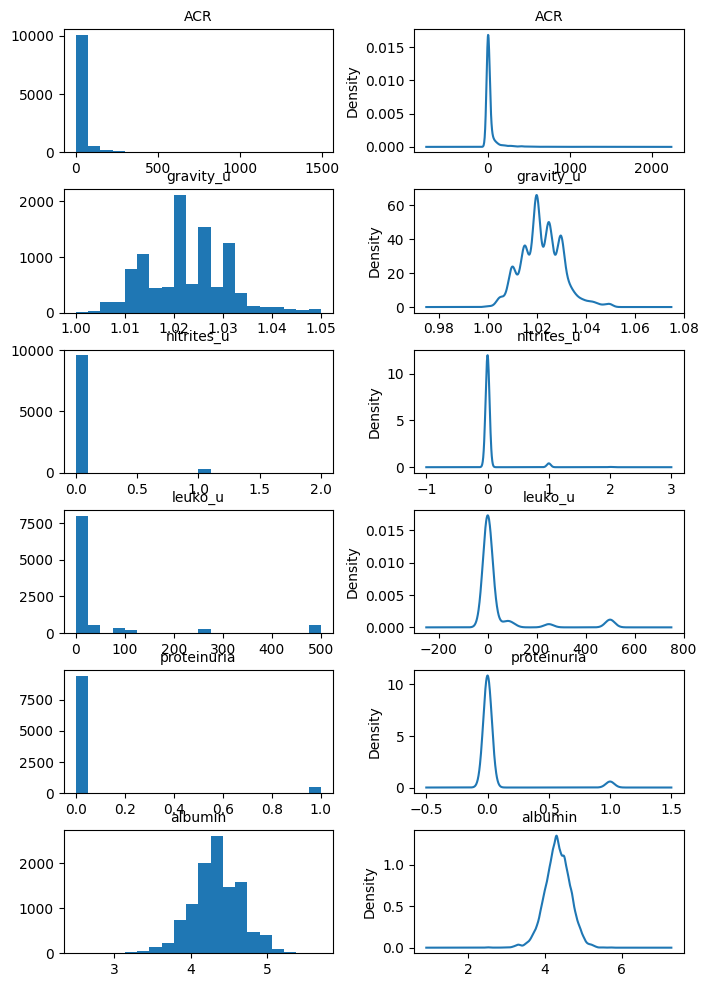

In [11]:
plot_null_features(train_df)

We'll first fix the **_ACR_** feature data by using the median and multiply it in normal distributed values

(<AxesSubplot: ylabel='Density'>,
 count    12438.000000
 mean        35.602297
 std        112.504761
 min          0.000000
 25%          3.520000
 50%          6.859953
 75%         18.040000
 max       1494.570000
 Name: ACR, dtype: float64)

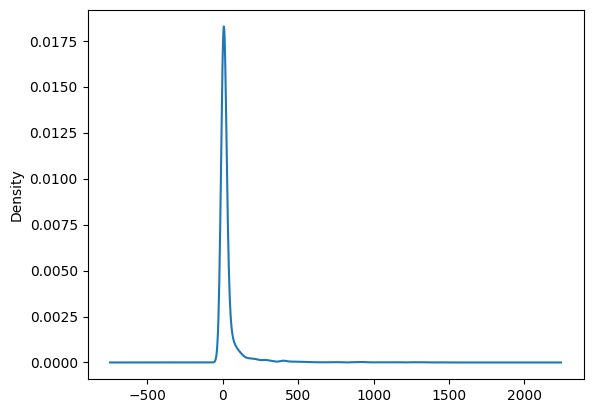

In [12]:
random_vals = pd.Series(np.abs(np.random.normal(size=1212)))
random_around_median = list(random_vals * train_df['ACR'].median())
acr_replacment = []
for i in train_df['ACR']:
    if math.isnan(i):
        acr_replacment.append(random_around_median.pop(0))
    else:
        acr_replacment.append(i)

train_df['ACR'] = pd.Series(acr_replacment)
train_df['ACR'].plot.kde(), train_df['ACR'].describe()

The **_gravity_u_** feature will be filled by previous row. The data distribution on albumin is more normal than gravity so well fill it with median whice is not sensetive to noise

In [13]:
train_df['gravity_u'] = train_df['gravity_u'].fillna(method='ffill')
train_df['albumin'] = train_df['albumin'].fillna(train_df['albumin'].median()) 

The description file helps to understand that cancer have no effect so we'll remove this attribute
albumin have 70%+ missing values
nitrites and protein, leuko have 20% missing data and more than 50% of zeros

In [14]:
train_df = train_df.drop(["cancer", "alb24h", "nitrites_u", "proteinuria", "leuko_u"], axis=1)
train_df.head()

age  sex marital_status  ses  residence_cd residence  weigh  heigh    BMI  \
0   49    2              U    1             1     urban   84.0  160.0  32.79   
1   46    2              M    1             1     urban   67.0  152.0  29.38   
2   46    2              U    1             1     urban   62.4  148.0  28.31   
3   45    1              U    2             1     urban   73.9  166.0  26.85   
4   49    2              U    1             1     urban   53.0  161.0  20.45   

   bp_sys  ...  Charlson framingham_cvd  antidiabetics ERD  CVD  HTN  \
0     116  ...         1        0.12908              1   0    0    1   
1     113  ...         1        0.08500              1   0    0    0   
2     133  ...         1        0.10715              1   0    0    1   
3     100  ...         1        0.10110              1   0    0    0   
4     110  ...         1        0.03950              1   0    0    0   

   cardiovascular_meds  statines  immigrant  dead_5y  
0                    1         1          0        0  
1                    1         1          0        0  
2                    1         1          0        0  
3                    0         1          0        0  
4                    0         1          0        0  

[5 rows x 40 columns]

In [15]:
# Transform the sex feature to binary - {1,2} --> {0,1}
train_df['sex'] = train_df['sex'] - 1
train_df['sex'].value_counts()

0    6607
1    5831
Name: sex, dtype: int64

#### Strings features

In [16]:
train_df.select_dtypes(exclude=['int64', 'float64'])

marital_status residence   bp_cat  smoking_status
0                  U     urban   Normal      non_smoker
1                  M     urban   Normal      non_smoker
2                  U     urban  Pre-HTN      non_smoker
3                  U     urban   Normal  current_smoker
4                  U     urban   Normal      non_smoker
...              ...       ...      ...             ...
12433              U     urban  Pre-HTN      non_smoker
12434              M     urban   Normal      non_smoker
12435              U     urban   Normal  current_smoker
12436              M     urban   Normal      non_smoker
12437              M     urban   Normal  current_smoker

[12438 rows x 4 columns]

In [17]:
train_df['residence'].value_counts(), train_df['residence_cd'].value_counts()

(urban    11659
 rural      779
 Name: residence, dtype: int64,
 1    11659
 2      779
 Name: residence_cd, dtype: int64)

We can drop the string residence column since the residence and residence_cd columns both contain the same values. same for smoking

In [18]:
train_df = train_df.drop(["residence"], axis=1)

In [19]:
train_df['smoking_status'].value_counts(), train_df['smoking'].value_counts()

(non_smoker        7806
 current_smoker    3287
 past_smoker       1345
 Name: smoking_status, dtype: int64,
 1    7806
 3    3287
 2    1345
 Name: smoking, dtype: int64)

In [20]:
train_df = train_df.drop(columns='smoking_status', axis=1)

Married = 1, Unmarried = 0

In [21]:
train_df['marital_status'] = train_df['marital_status'].map({"U" : 0, "M": 1})


Converting string to integrs.

In [22]:
train_df['bp_cat'] = train_df['bp_cat'].map({"Normal": 0, "Pre-HTN": 1, "HTN-G1": 2, "HTN-G2": 3, "HTN-G3": 4}).astype(int)

We're done dealing with the features conatined nulls and strings.

#### Correlation - In the following part we'll deal with feature selection in order to avoid multicollinearity 

The first table shows the countnious features correlation, we'll deal the categorical features later.

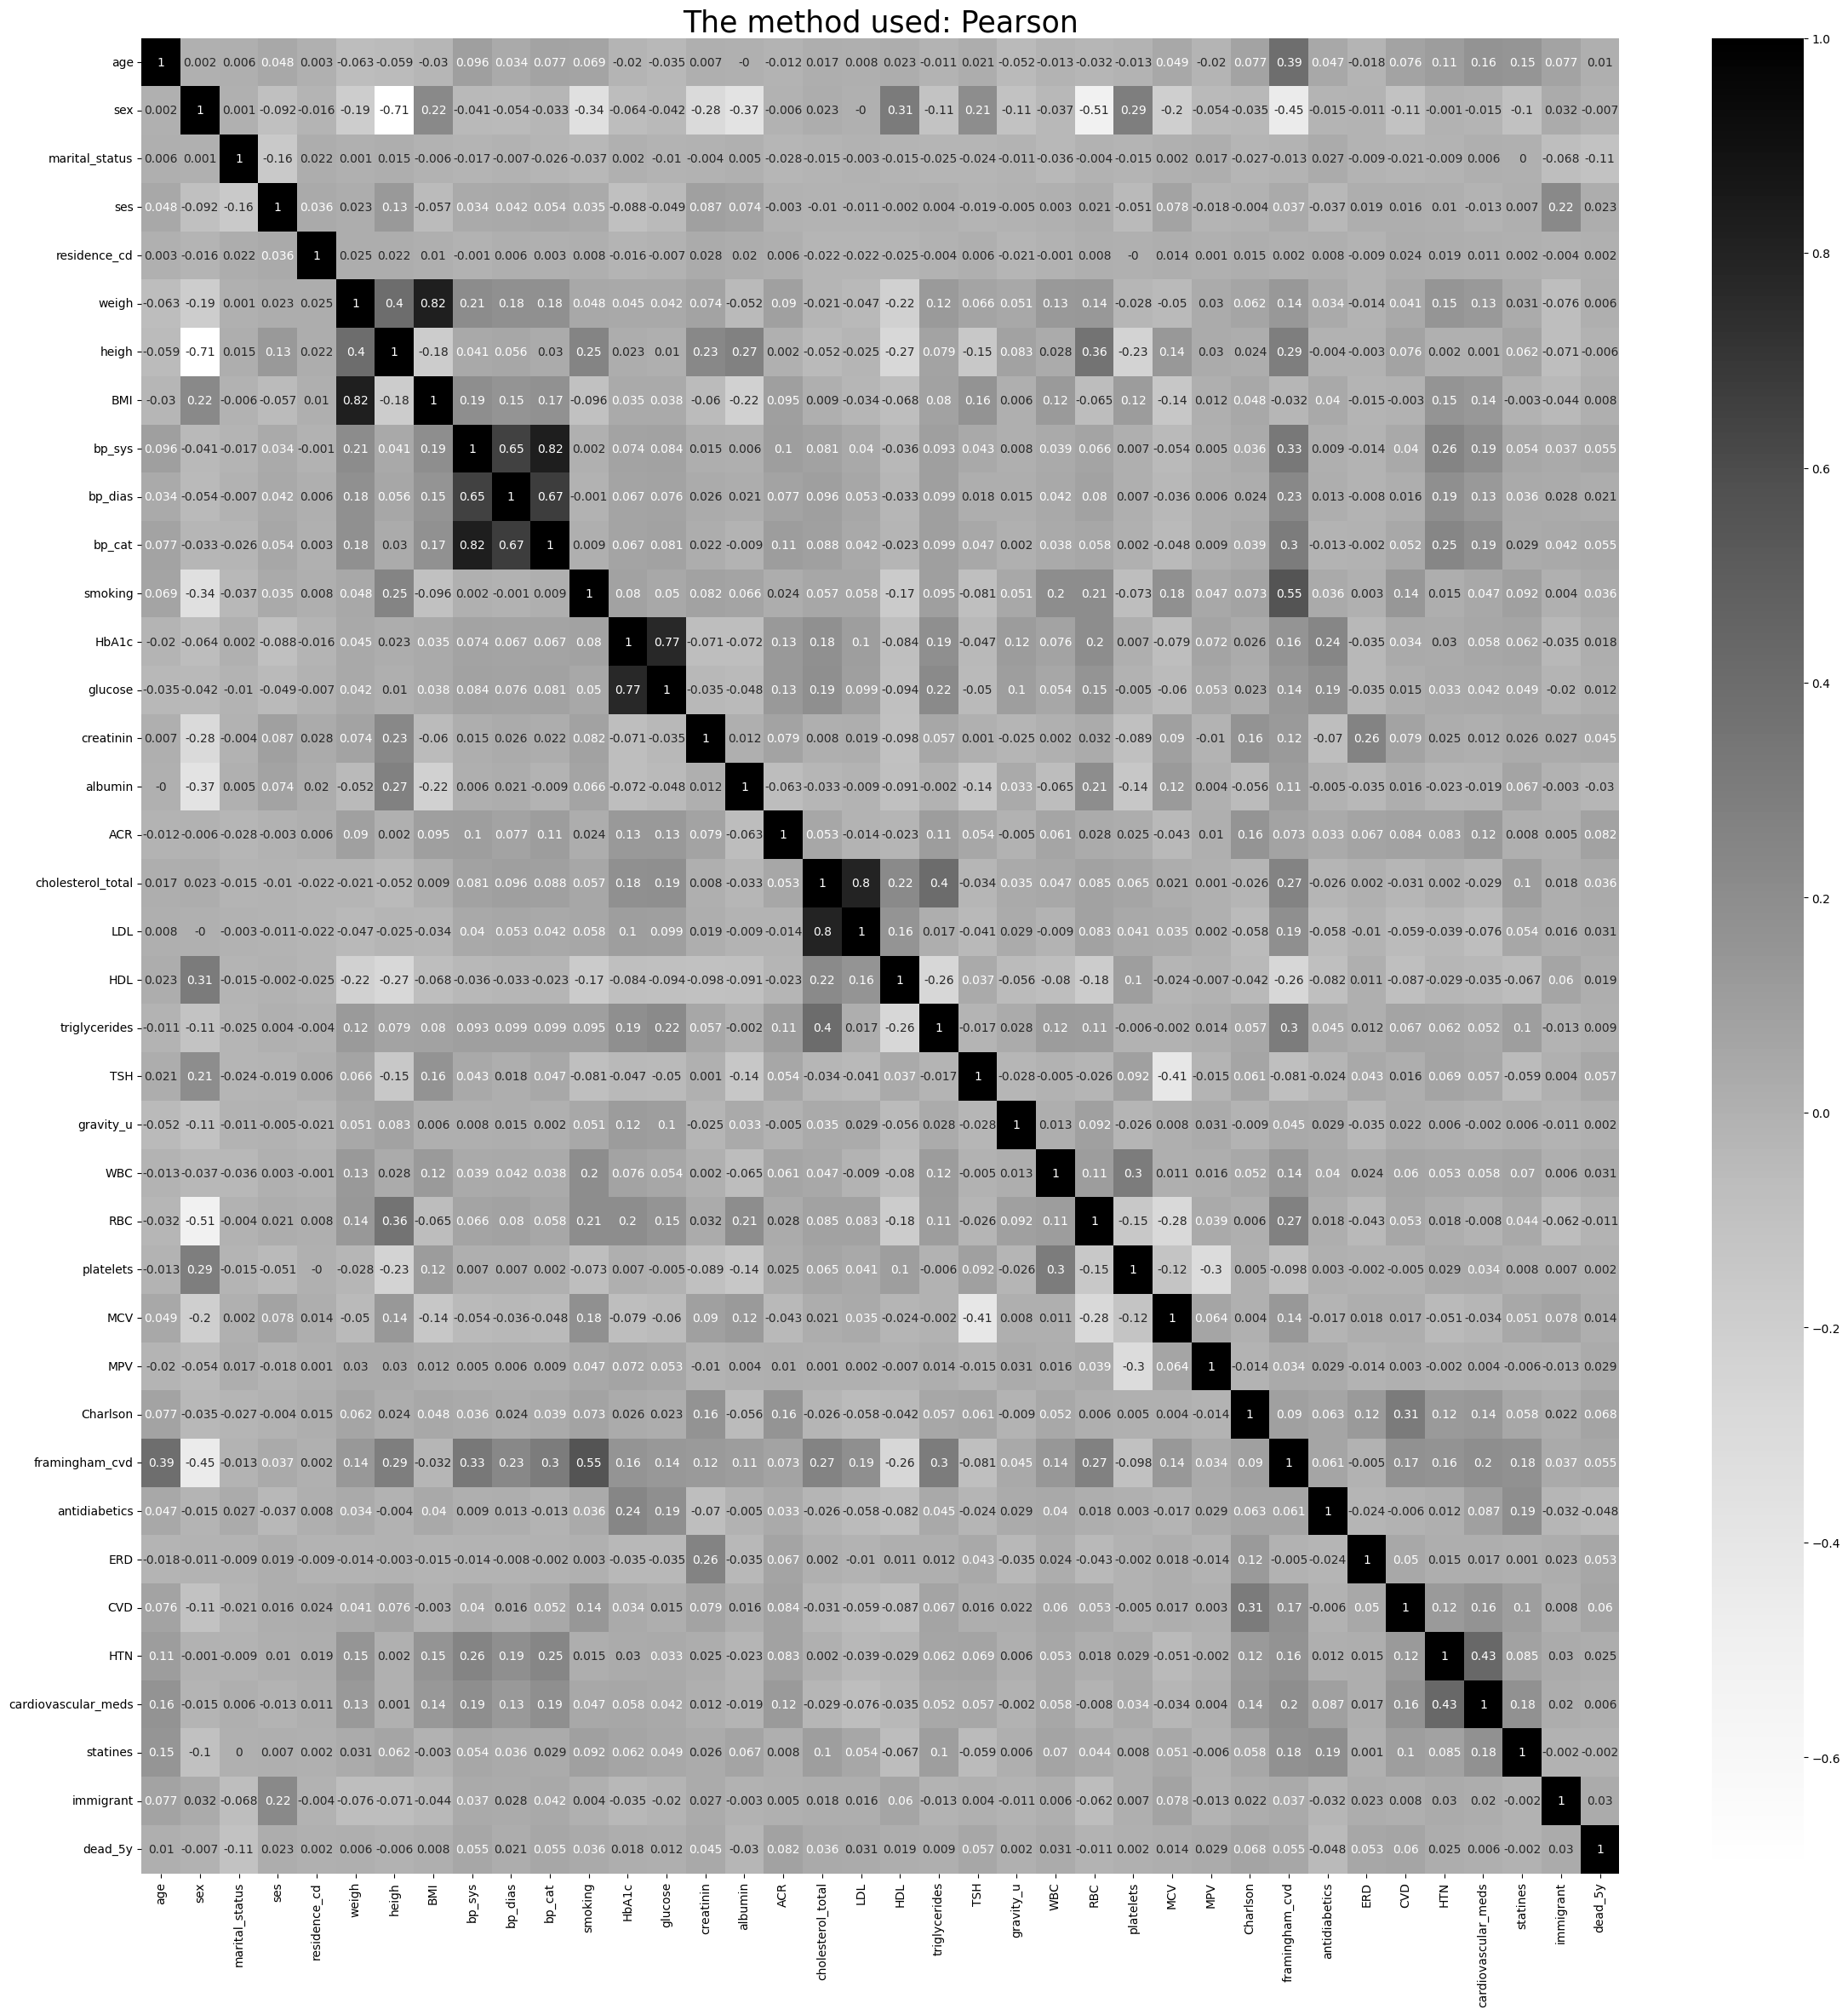

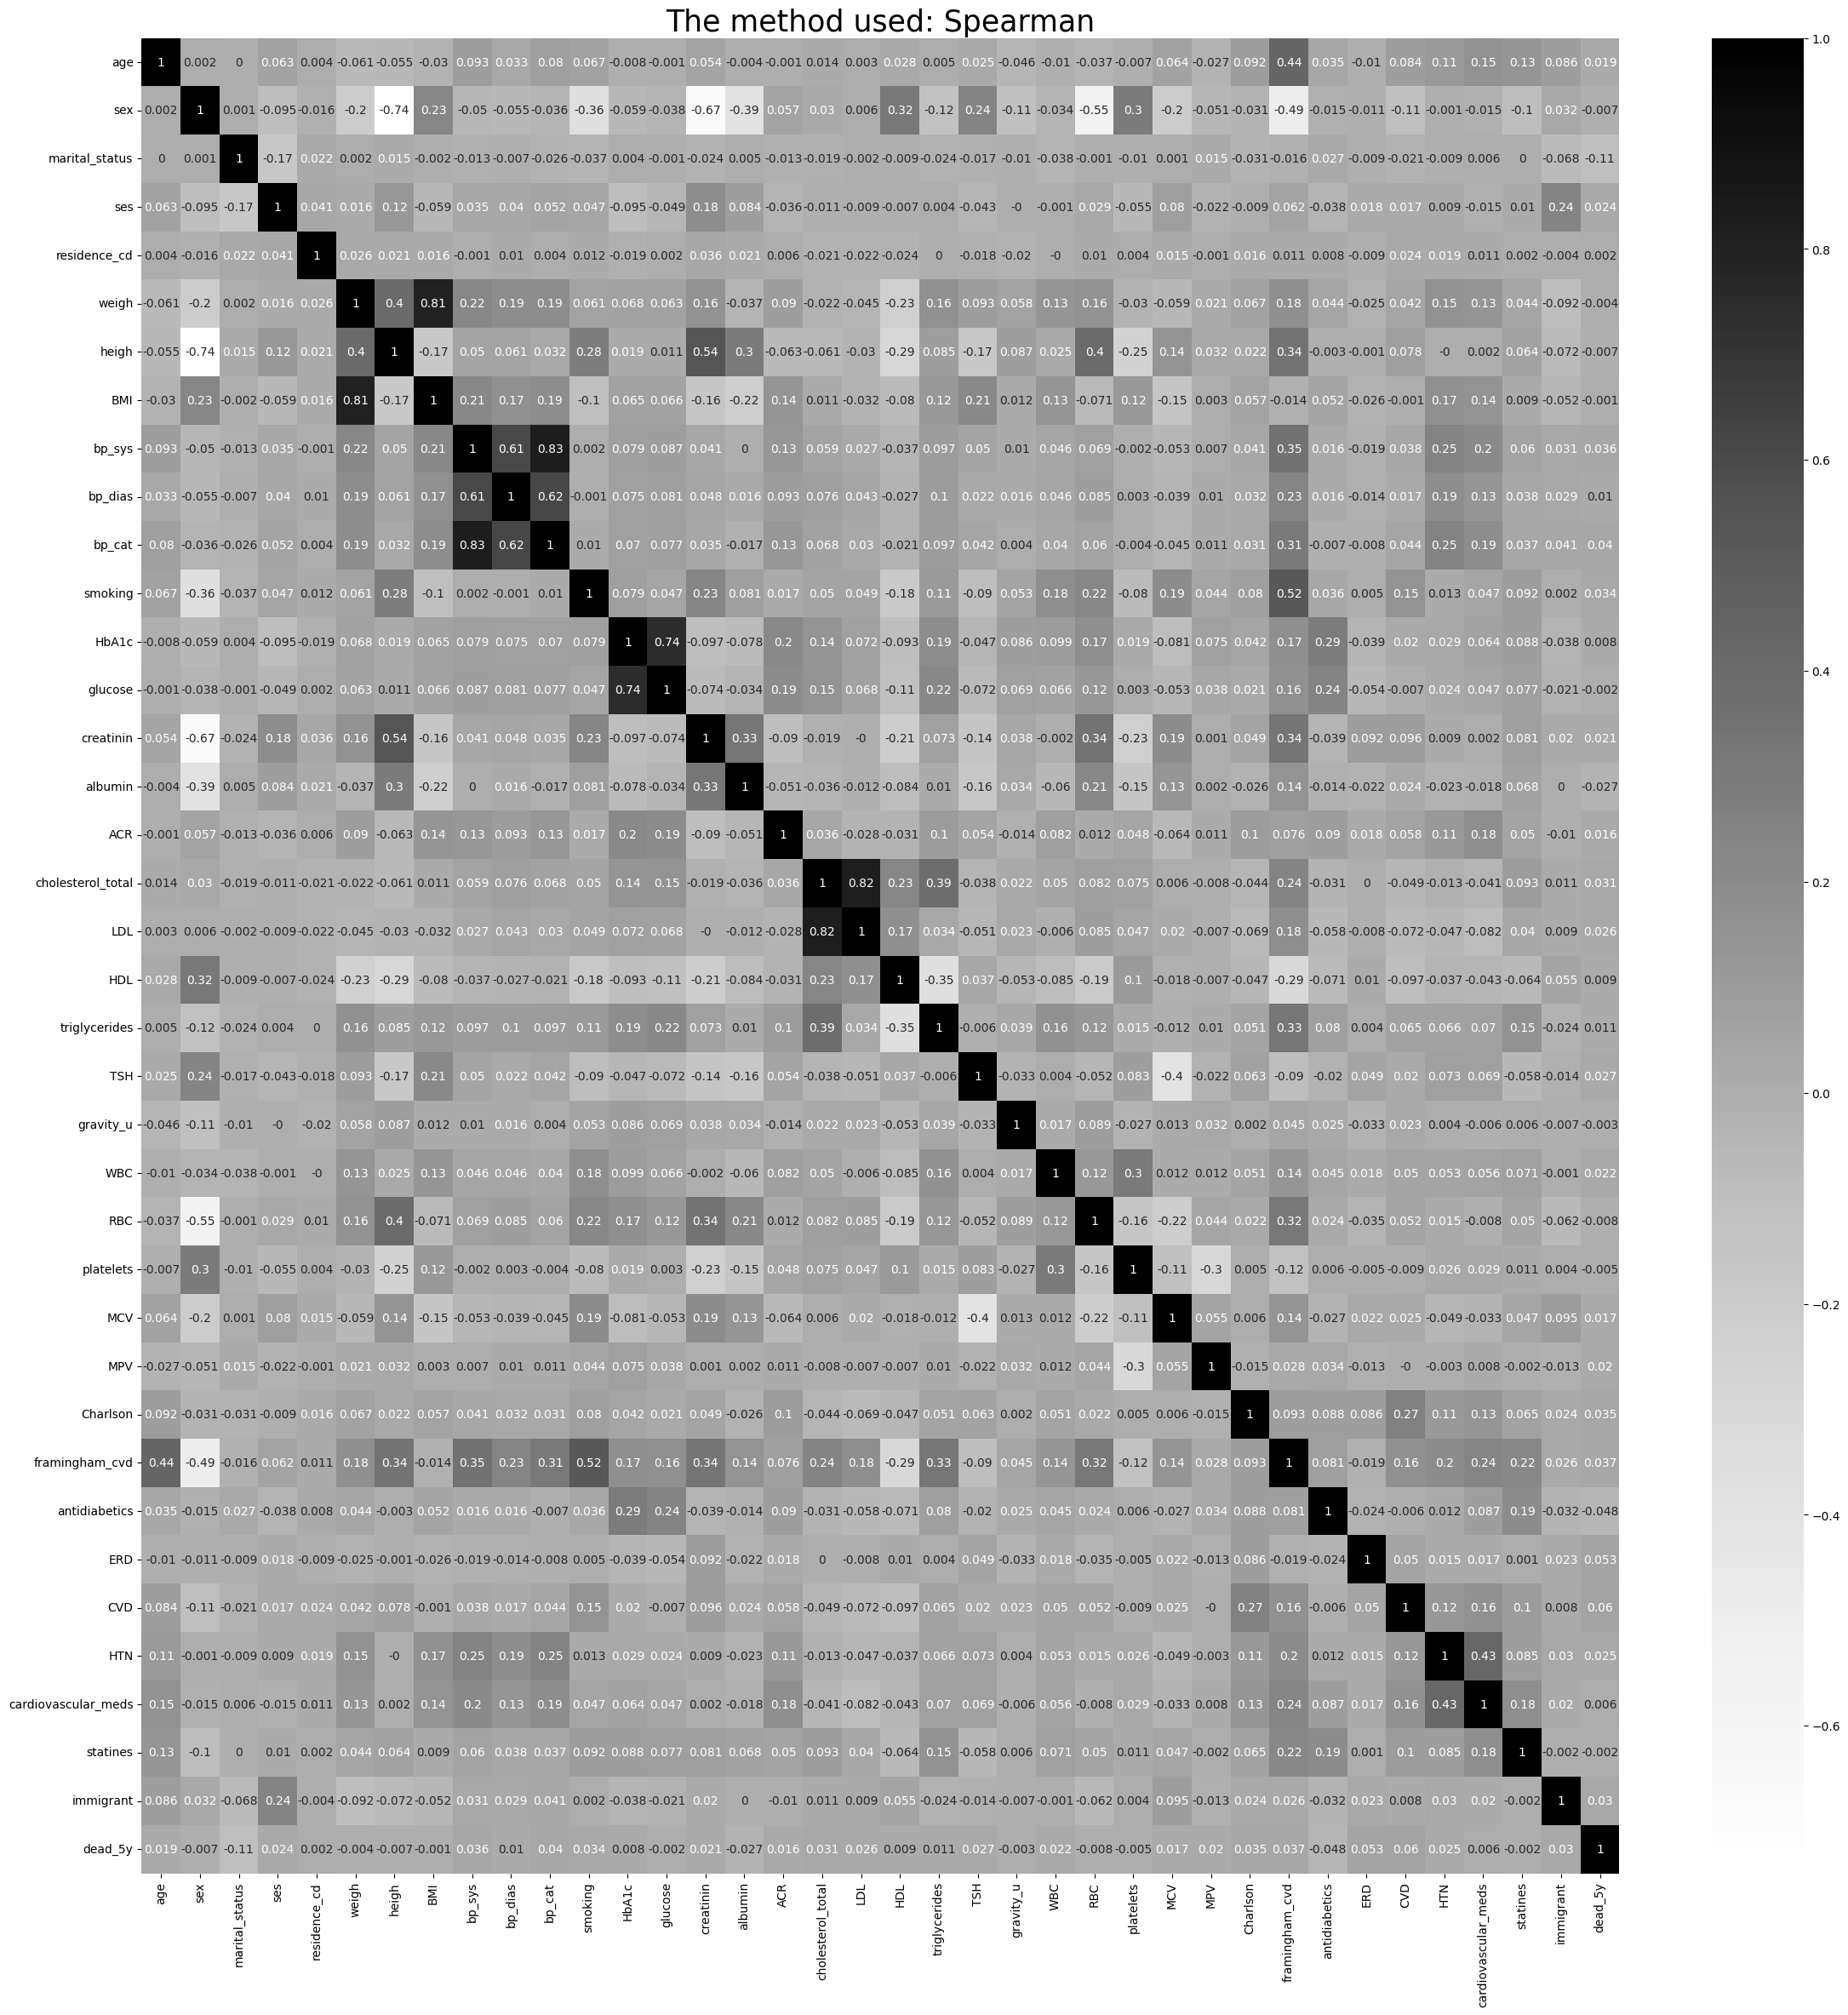

(None, None)

In [23]:
plot_correlation(train_df), plot_correlation(train_df, 'spearman')

High correlation between bp_sys and bp_dias to bp cat so we use pca to reduce the dimensions and get two orthogonal vectors

In [24]:
# Save the data after transformation
train_df.to_csv('new_dataset.csv')

In [25]:
bp_pca = train_df[['bp_sys', 'bp_dias', 'bp_cat']]
pca = skl.decomposition.PCA(n_components=2)
pca.fit(bp_pca)
data_pca = pca.transform(bp_pca)
col_dict = col_to_num(train_df)
index = min(col_dict['bp_sys'],col_dict['bp_cat'], col_dict['bp_dias'])
train_df.insert(index, "new_bp_pca_1", 0)
train_df.insert(index+1, "new_bp_pca_2", 0)
train_df['new_bp_pca_1'] = data_pca[:, 0]
train_df['new_bp_pca_2'] = data_pca[:, 1]

לא סומכים על מדד הביאמי שניתן לנו, ניתן לראות שבחישוב מקומי הגדלנו את הקורלציות.

In [26]:
cor1 = train_df['BMI'].corr(train_df['weigh'])
cor2 = train_df['BMI'].corr(train_df['heigh'])
print(f'BMI <-> weigh {cor1:<.4}, BMI <-> heigh {cor2:<.4}')
train_df['BMI'] = train_df['weigh'] / (train_df['heigh'] ** 2)
cor1 = train_df['BMI'].corr(train_df['weigh'])
cor2 = train_df['BMI'].corr(train_df['heigh'])
print(f'BMI <-> weigh {cor1:<.4}, BMI <-> heigh {cor2:<.4}')

BMI <-> weigh 0.817, BMI <-> heigh -0.1784
BMI <-> weigh 0.8226, BMI <-> heigh -0.1803


In [27]:
train_df.to_csv('new_dataset.csv')

LDL and cholesterol total have high correlation, let's study it

(<AxesSubplot: xlabel='LDL', ylabel='Density'>,
 <AxesSubplot: xlabel='cholesterol_total', ylabel='Density'>)

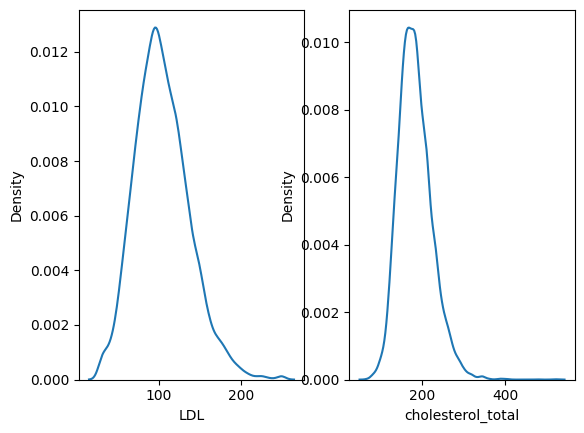

In [28]:
fig = plt.figure()
ax = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)
sns.kdeplot(train_df['LDL'], ax=ax), sns.kdeplot(train_df['cholesterol_total'], ax=ax1)

In [29]:
cor = train_df.corr()
cor['cholesterol_total'].loc[(np.abs(cor['cholesterol_total']) > 0.5) & (cor['cholesterol_total'] != 1)]

LDL    0.795632
Name: cholesterol_total, dtype: float64

We diceded to drop the cholesterol_total feature because it's high correlation and our understanding that LDL, triglycerides and HDL maps chorlesterol total and as we noticed on BMI feature we  can't trust this calculation


HbA1c and glucose are also in high correlation, multiplication helped to get high correlation from both features

In [30]:
print(train_df['HbA1c'].describe(), train_df['glucose'].describe())

count    12438.000000
mean         7.623666
std          1.867250
min          4.000000
25%          6.300000
50%          7.100000
75%          8.500000
max         16.800000
Name: HbA1c, dtype: float64 count    12438.000000
mean       153.757276
std         64.724782
min         40.000000
25%        110.000000
50%        134.000000
75%        177.000000
max        883.000000
Name: glucose, dtype: float64


In [31]:
train_df['mult_glu_HbA'] = train_df['HbA1c'] * train_df['glucose']

Let's take a look and spearman correlation matrix, more accurate for categorical features

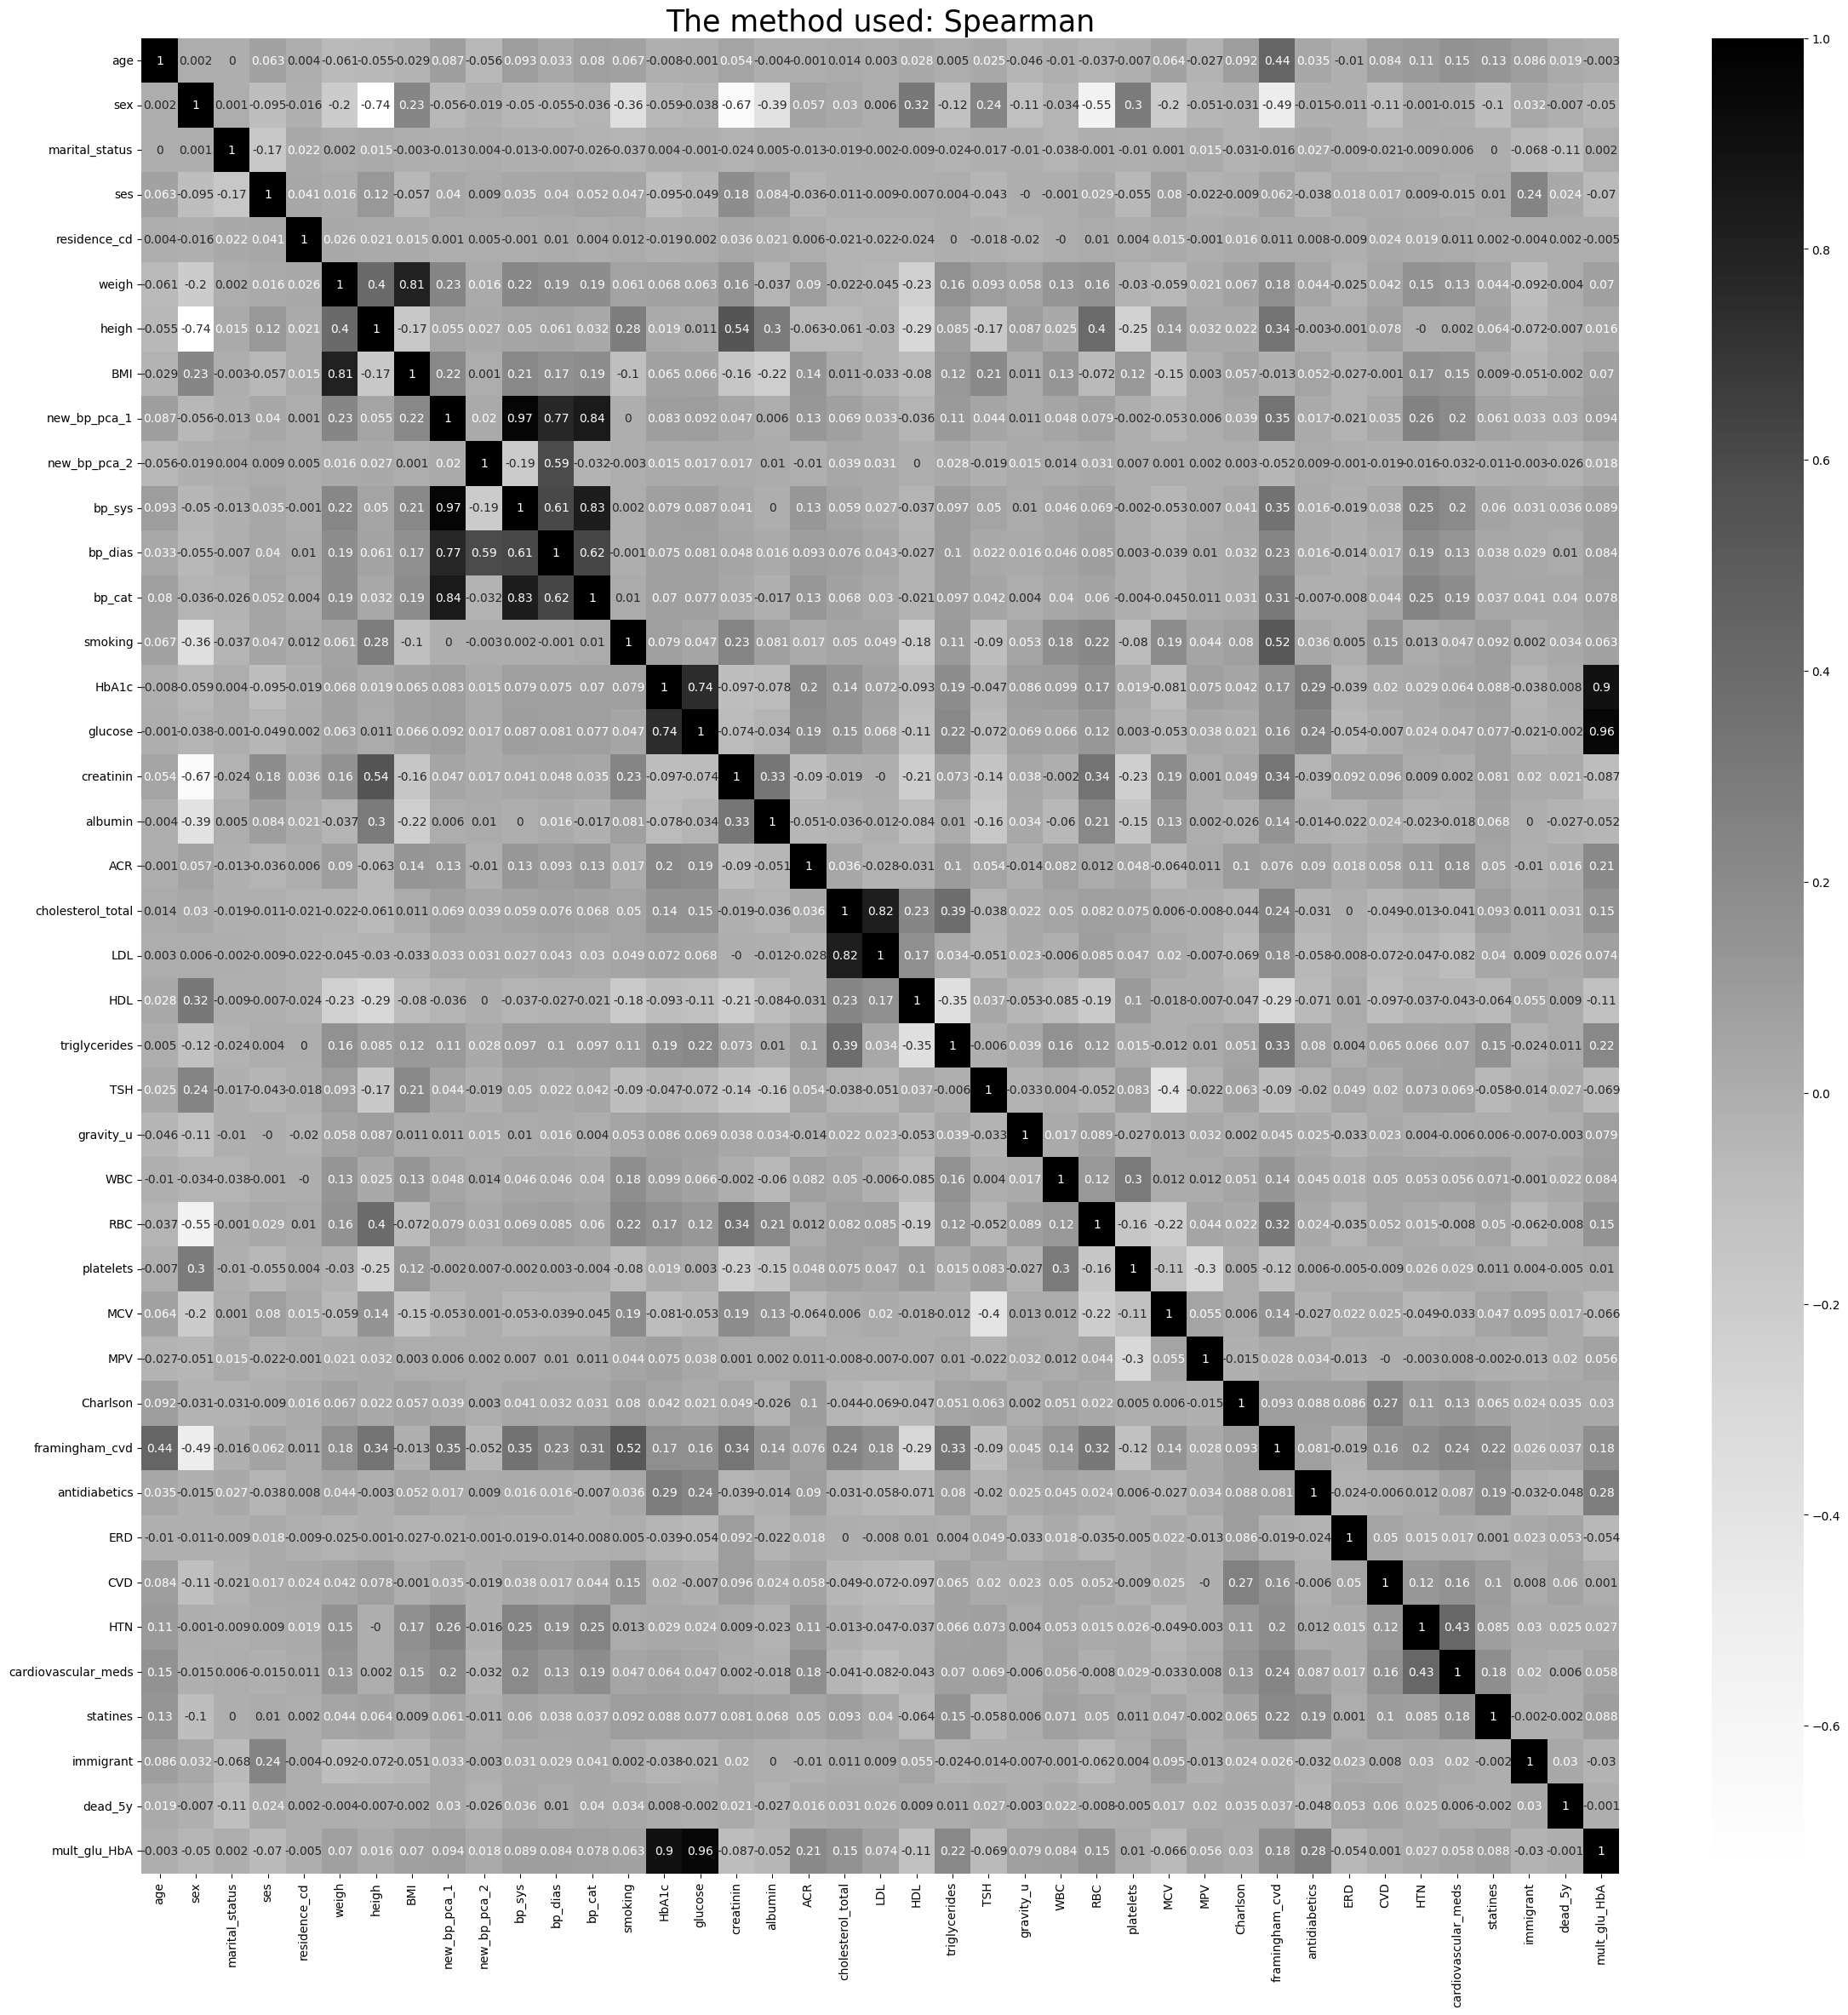

In [32]:
plot_correlation(train_df, 'spearman')

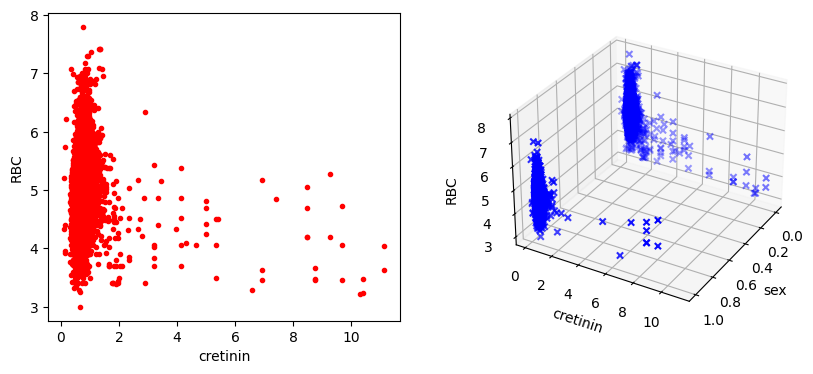

In [33]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1,2,2, projection='3d')
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(train_df['creatinin'], train_df['RBC'], marker='.', color='r')
ax1.set_xlabel('cretinin')
ax1.set_ylabel('RBC')
ax.scatter(train_df['sex'], train_df['creatinin'], train_df['RBC'], marker='x', color='b')
ax.set_xlabel('sex')
ax.set_ylabel('cretinin')
ax.set_zlabel('RBC', rotation=90)
ax.view_init(30, 30)

relations between sex and heigh make sense, we'll use TNSE for the dimension reduction because the data we want  to reduce is both binary and continous 

In [35]:
tsne = skl.manifold.TSNE(2)
p =  tsne.fit_transform(train_df[['sex', 'RBC', 'creatinin']])
index = min(col_dict['RBC'], col_dict['creatinin'])
train_df.insert(index, 'new_tnse_1', 0)
train_df.insert(index+1, 'new_tnse_2', 0)
train_df['new_tnse_1'] = p[:, 0]
train_df['new_tnse_2'] = p[:, 1]

Text(0, 0.5, 'new_tnse_2')

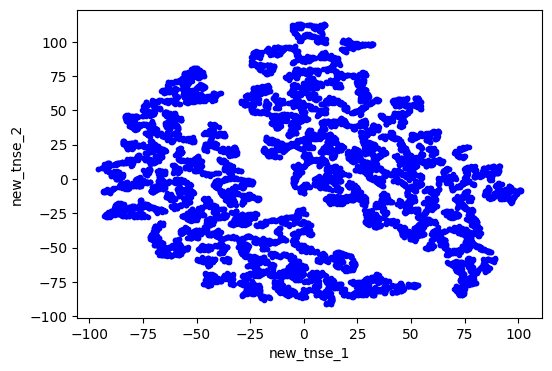

In [36]:
fig = plt.figure(figsize=(6, 4))
ax = plt.axes()
ax.scatter(train_df['new_tnse_1'], train_df['new_tnse_2'], marker='.', color='b')
ax.set_xlabel('new_tnse_1')
ax.set_ylabel('new_tnse_2')

Visualizing new features mapping for their origins

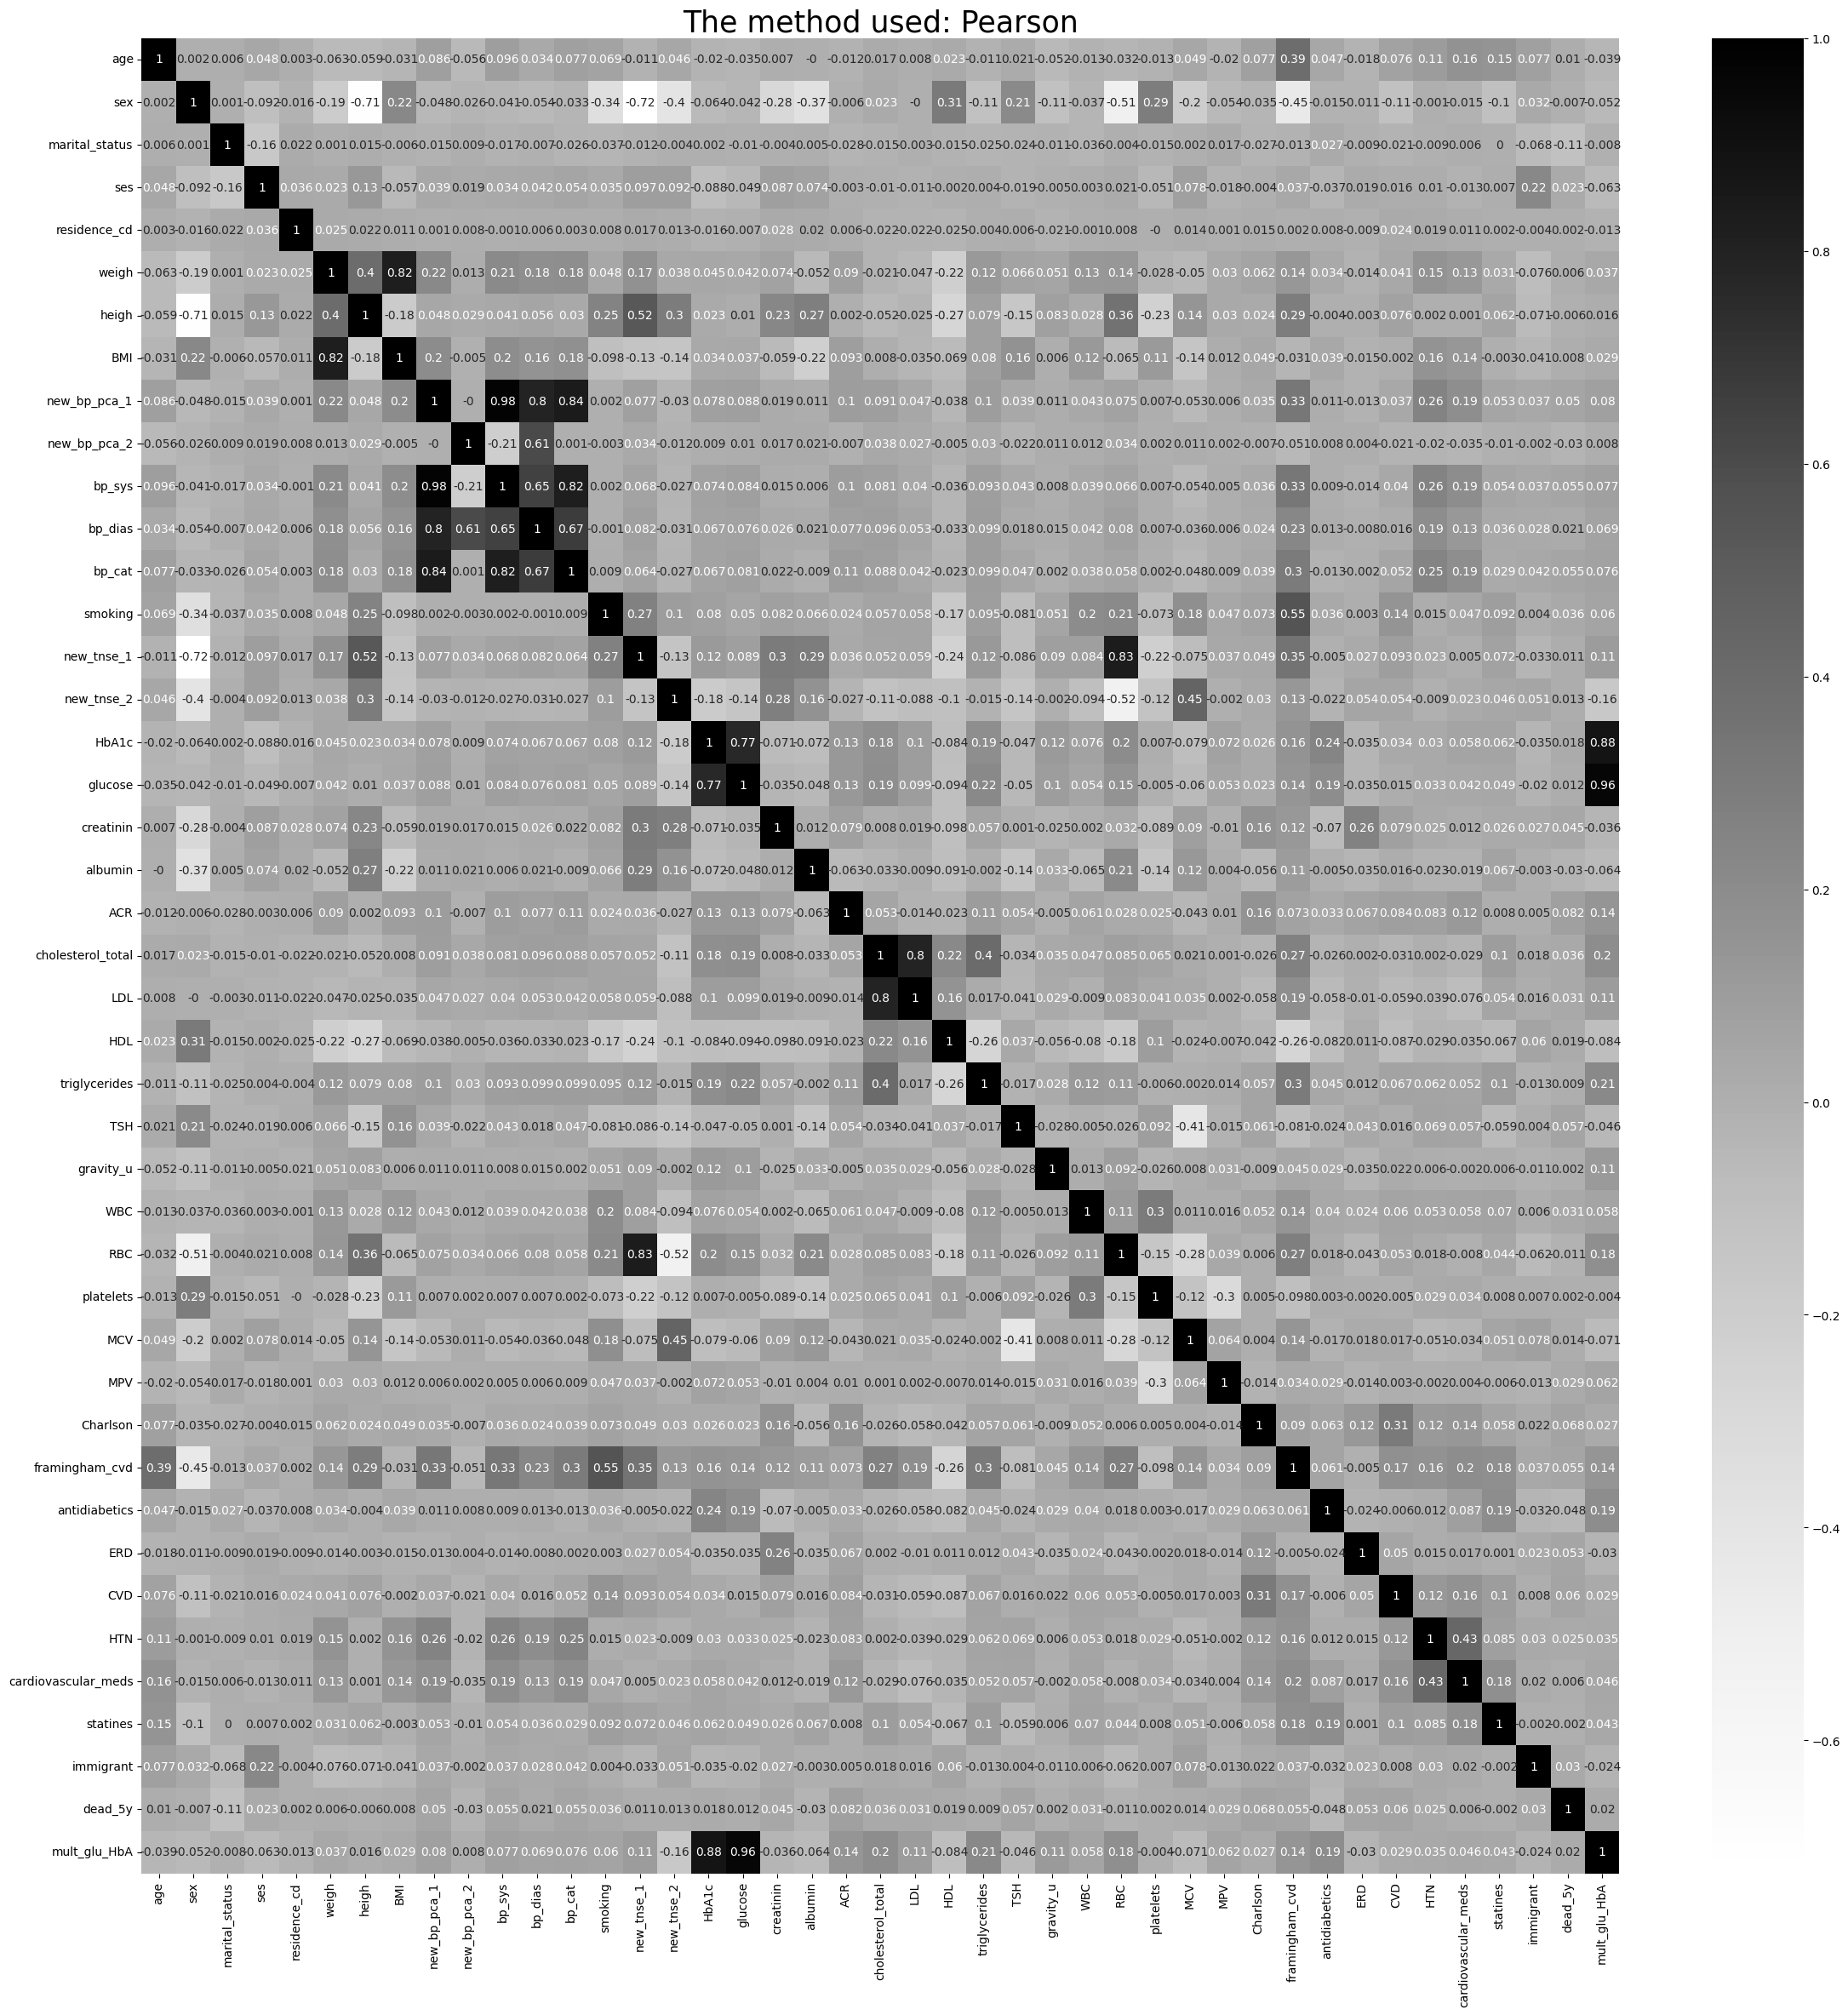

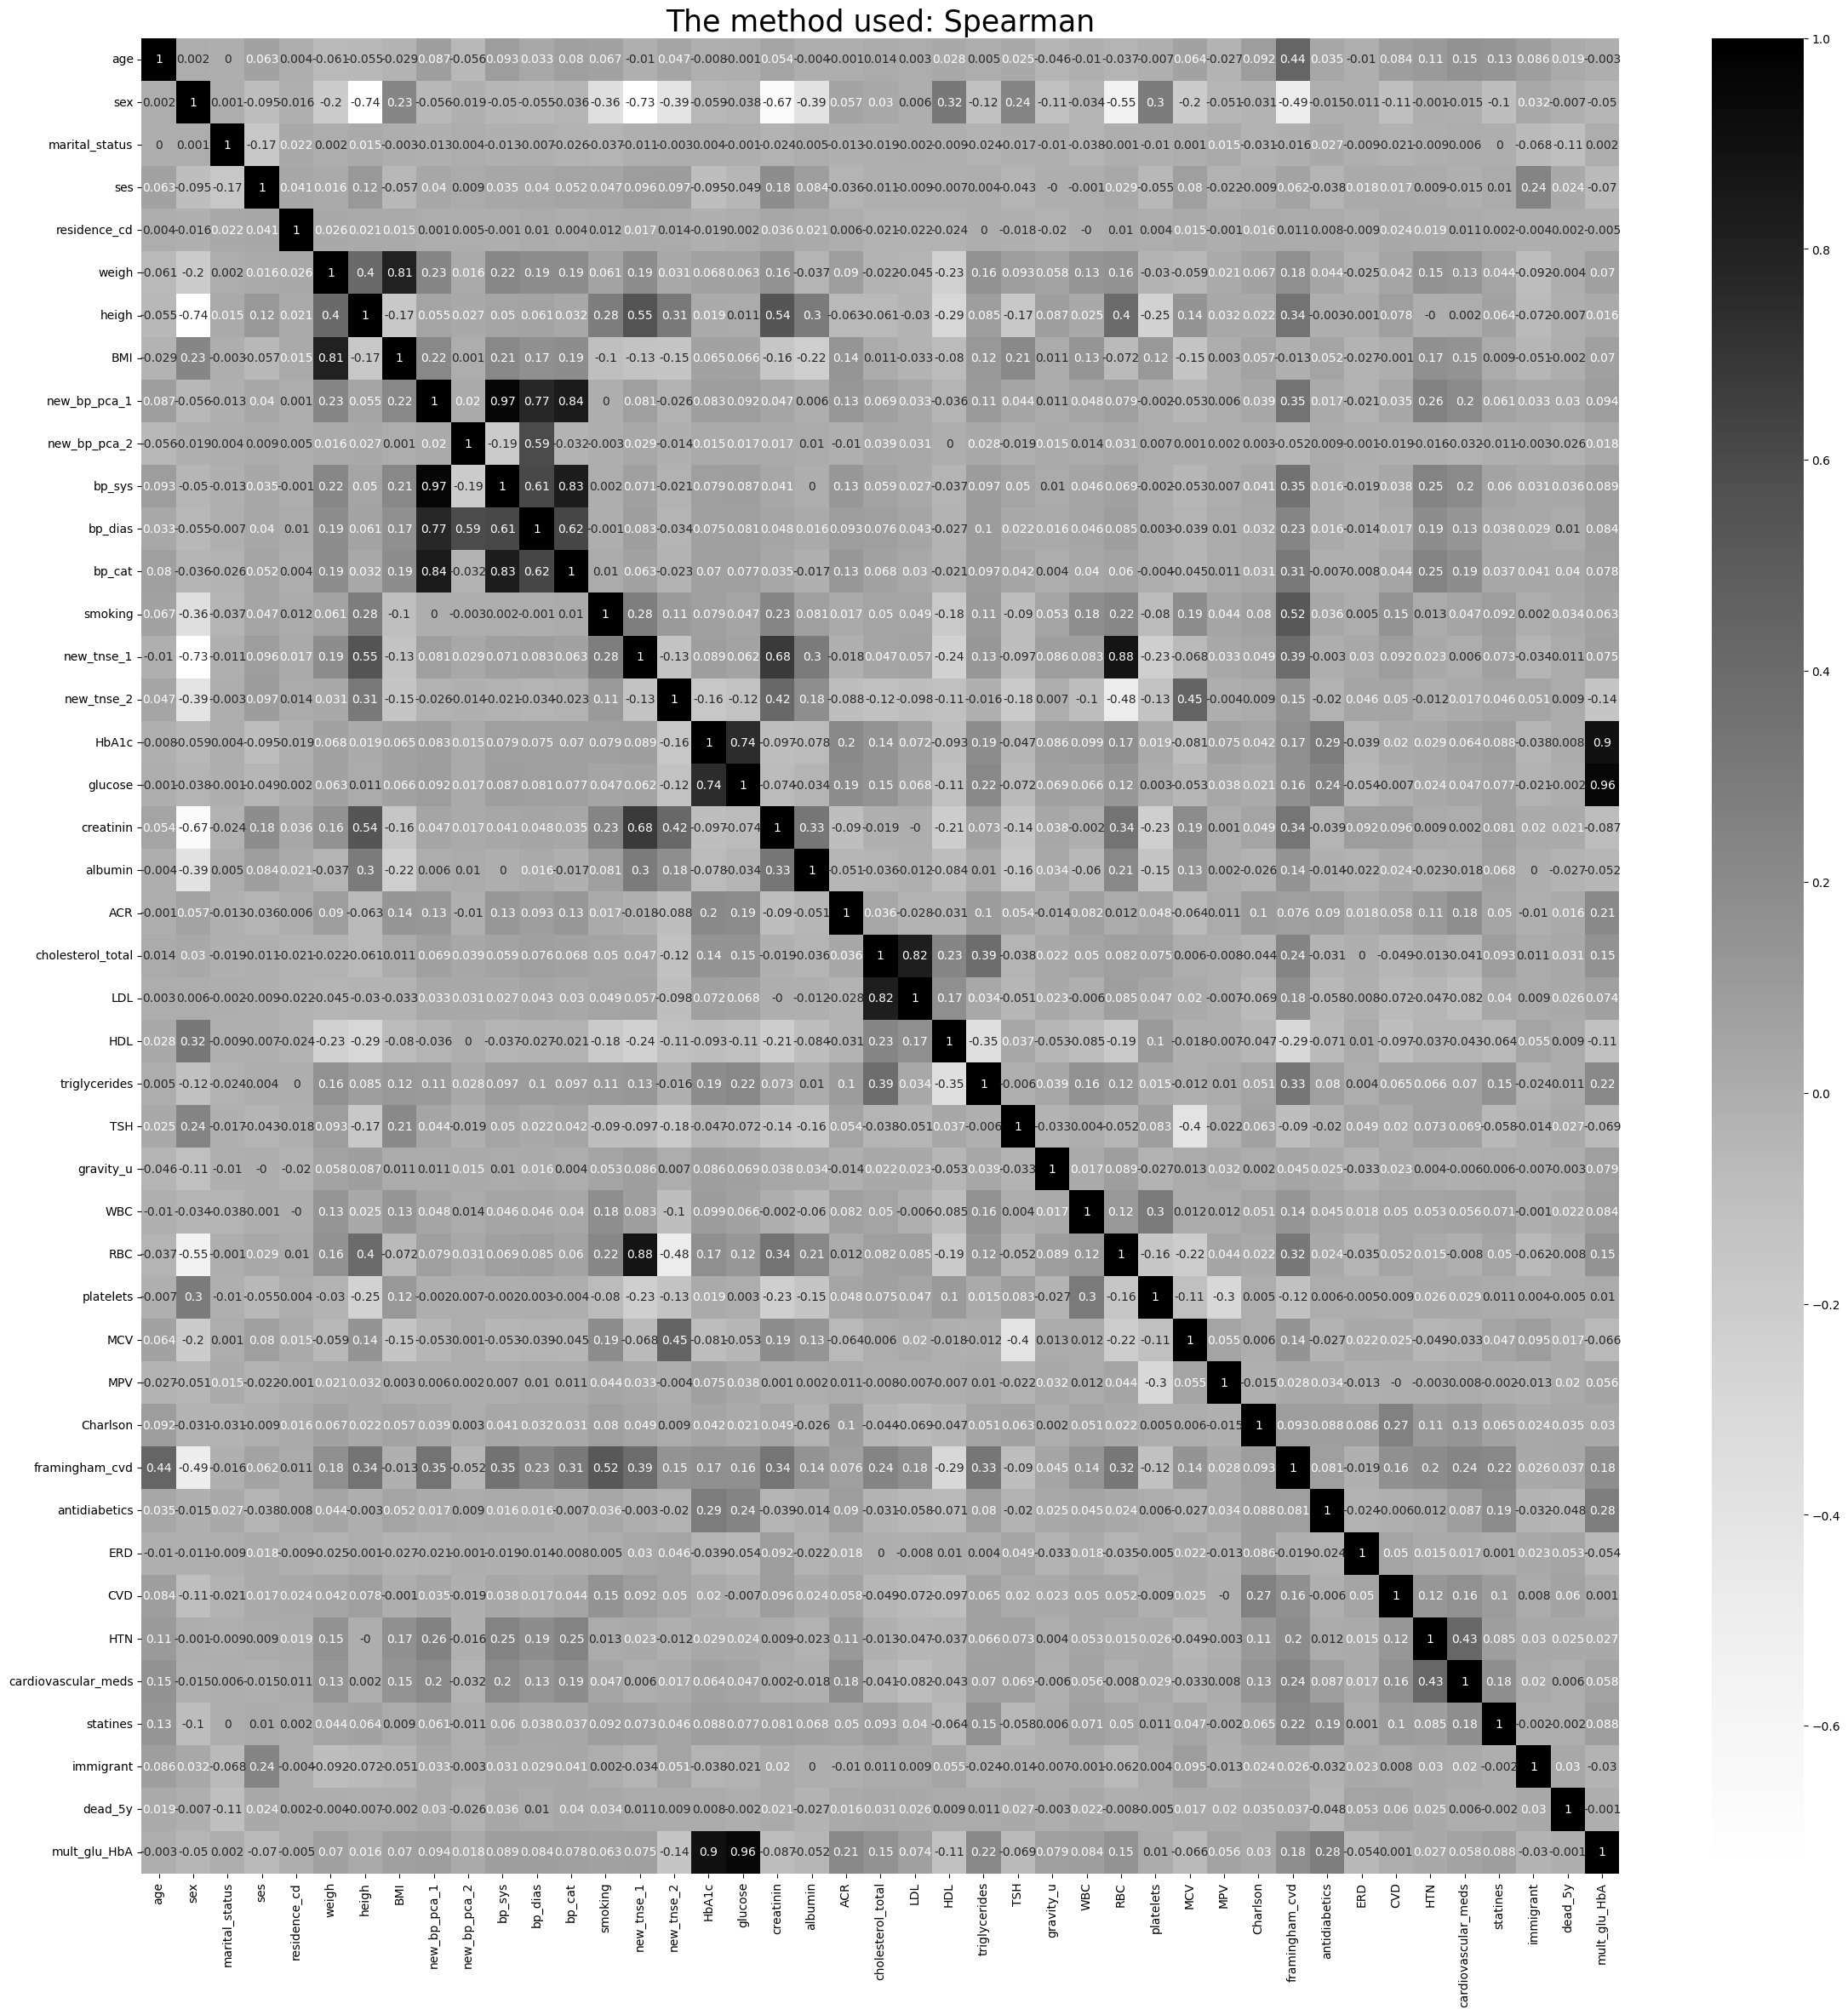

(None, None)

In [37]:
plot_correlation(train_df), plot_correlation(train_df, 'spearman')

In [38]:
train_df = train_df.drop(['bp_sys', 'bp_dias', 'bp_cat', 'weigh', 'heigh',
'cholesterol_total', 'HbA1c', 'glucose', 'sex', 'RBC', 'creatinin'], axis=1)

Understaing the relations between farmingham rate and smoking

In [39]:
cvd_mean = train_df['framingham_cvd'].mean()

In [40]:
# Number of death people that are smoking and have high framingham rate
train_df['framingham_cvd'].loc[(train_df['framingham_cvd'] > cvd_mean) &(train_df['smoking'] > 1) & (train_df['dead_5y'] == 1)].count()

71

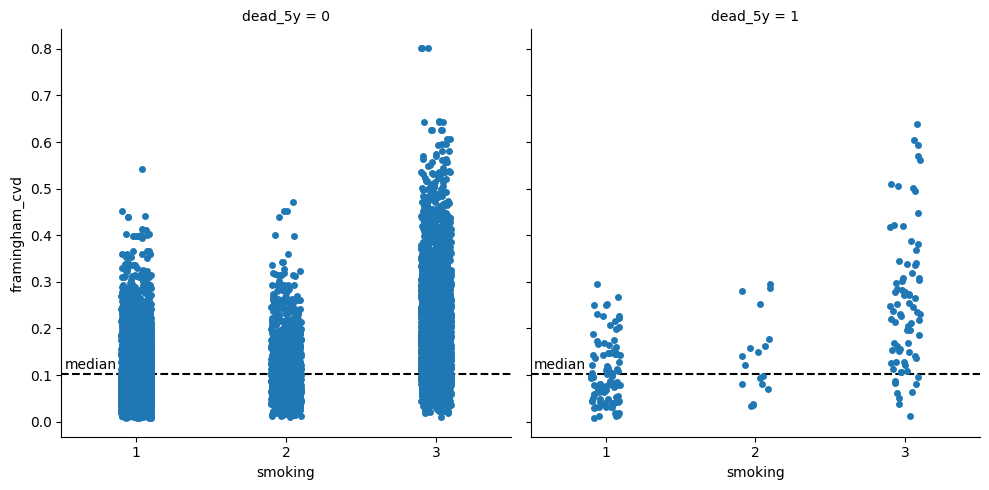

In [41]:
data = train_df[['framingham_cvd', 'smoking','dead_5y']]
f = sns.catplot(data=data, x='smoking', y='framingham_cvd', col='dead_5y')
f.axes[0][0].axhline(y=train_df['framingham_cvd'].median(), color='black', ls='--')
f.axes[0][0].text(-0.48, y=train_df['framingham_cvd'].median()+0.01, s='median')
f.axes[0][1].text(-0.48, y=train_df['framingham_cvd'].median()+0.01, s='median')
f.axes[0][1].axhline(y=train_df['framingham_cvd'].median(), color='black', ls='--')

In [42]:
train_df = train_df.drop(['framingham_cvd'], axis=1)
train_df.shape

(12438, 31)

Now, correlations are removed

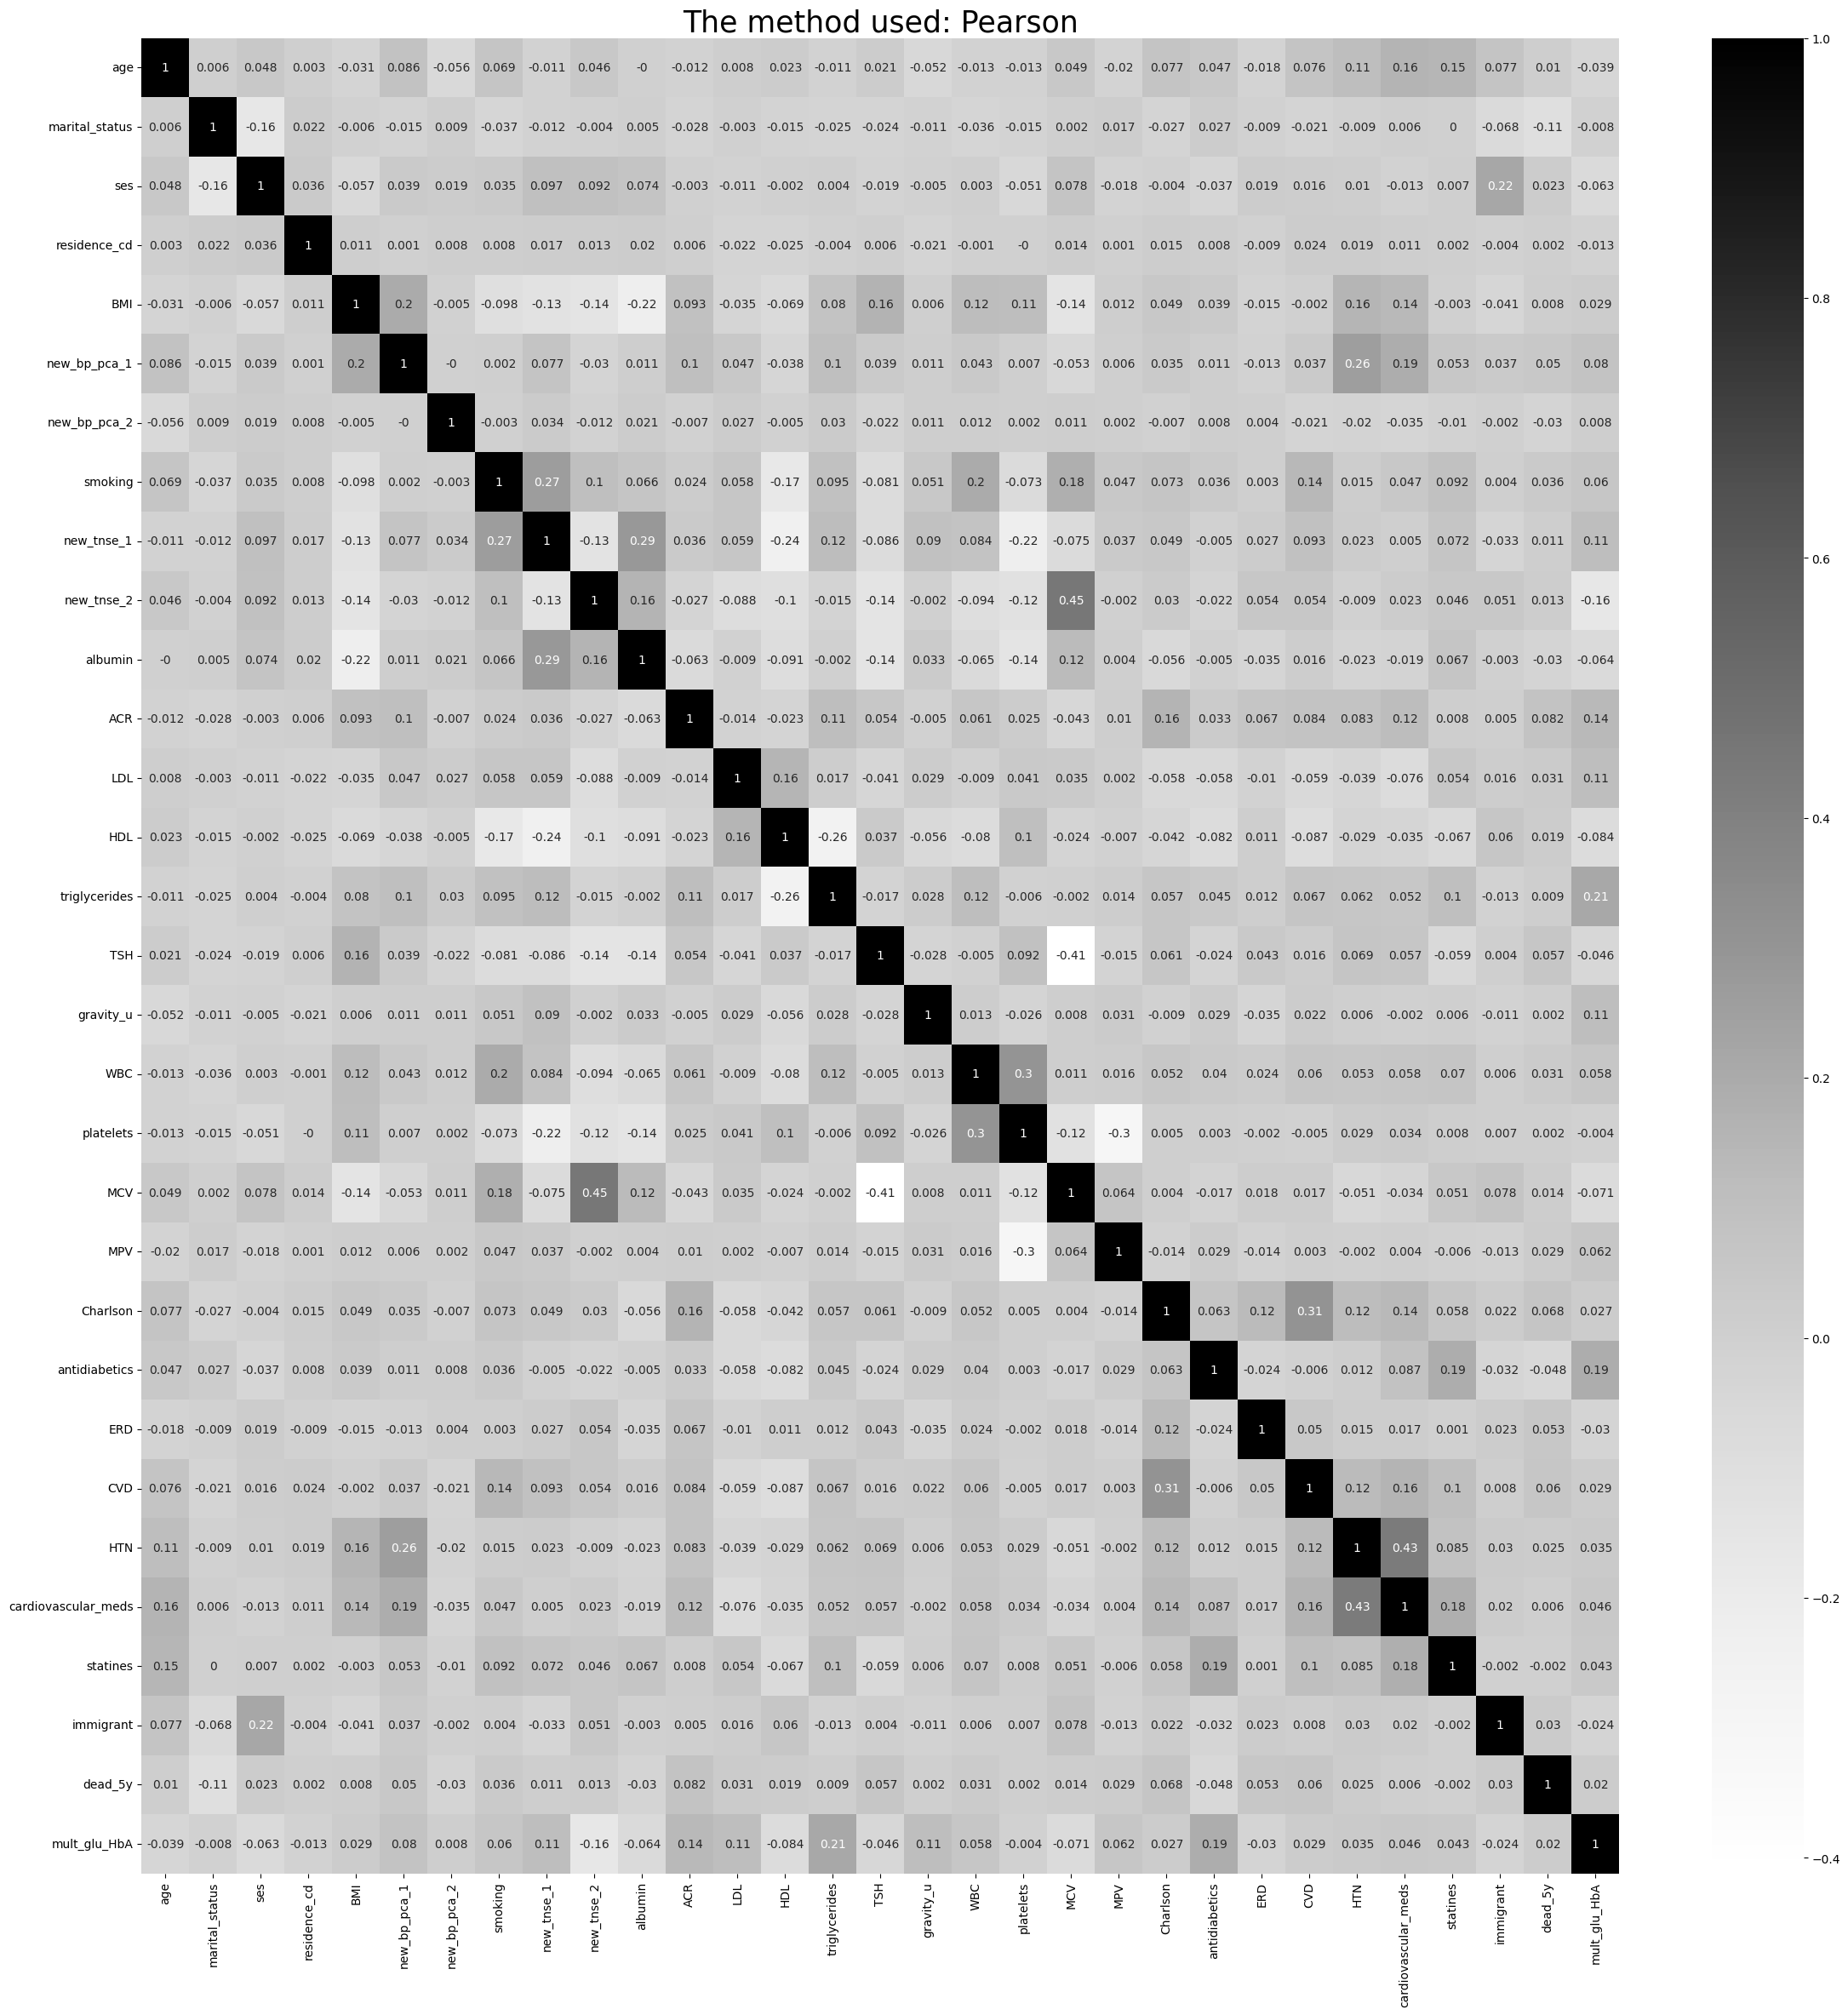

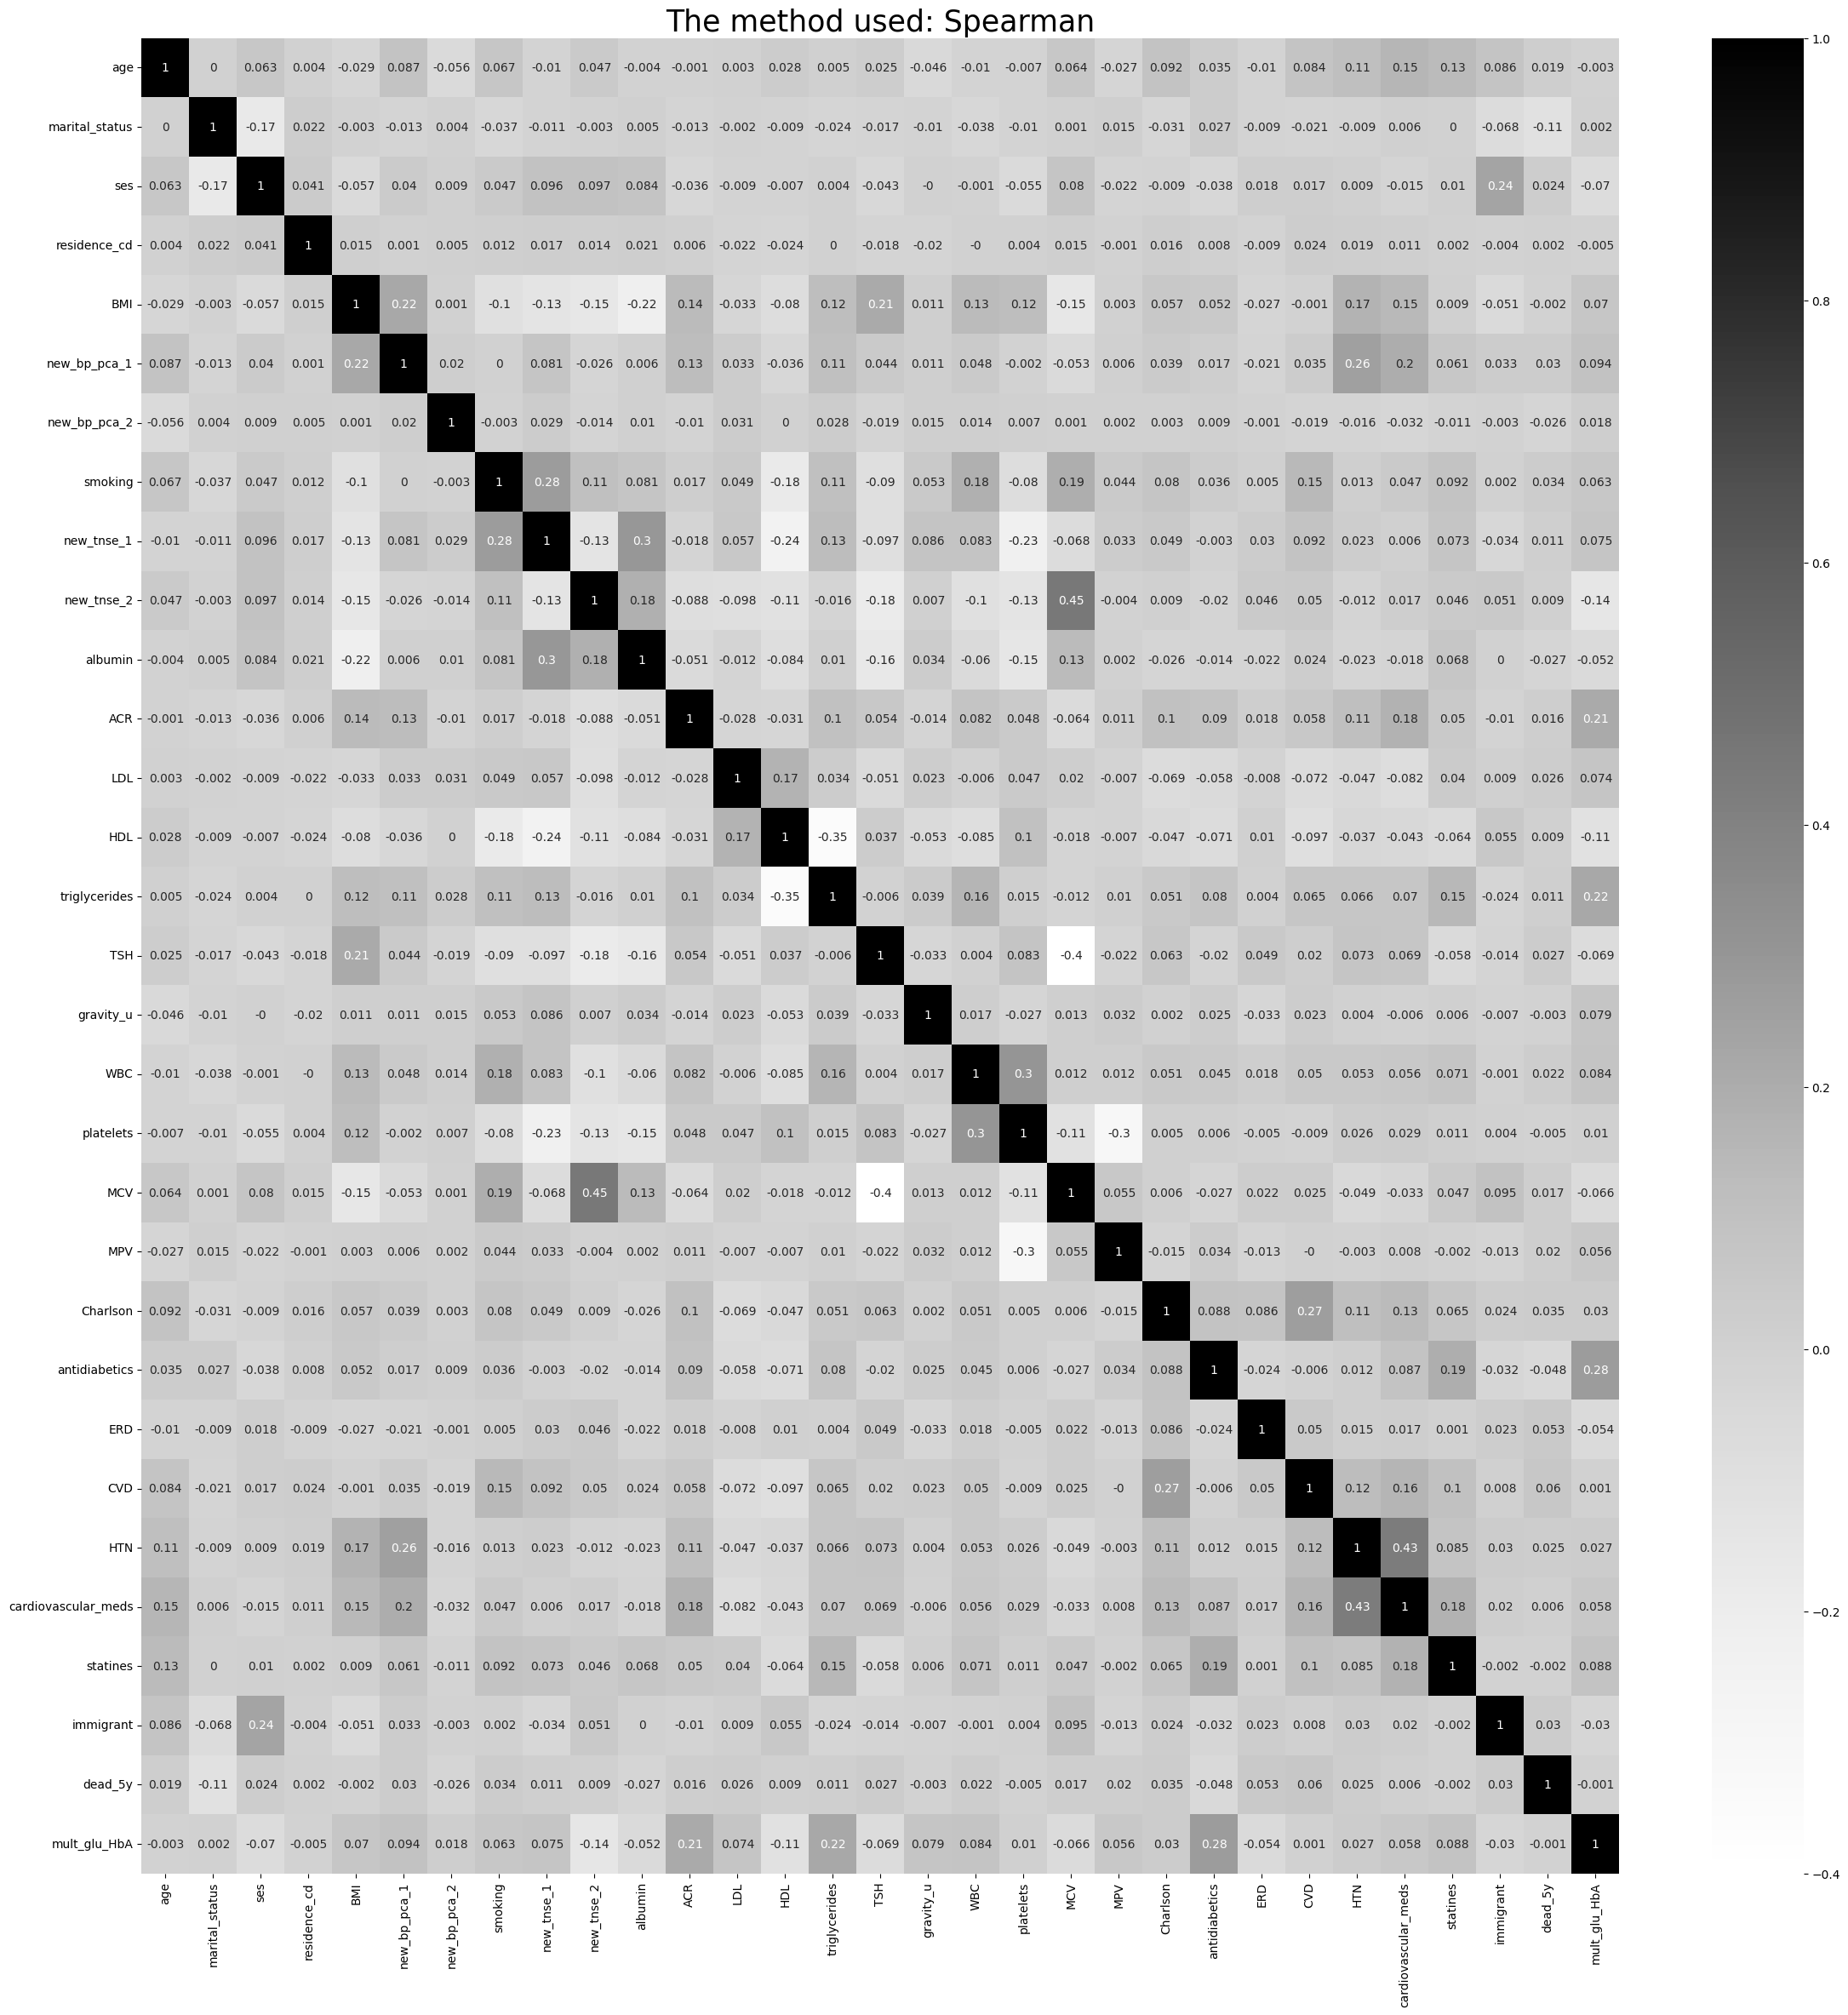

(None, None)

In [43]:
plot_correlation(train_df), plot_correlation(train_df, 'spearman')

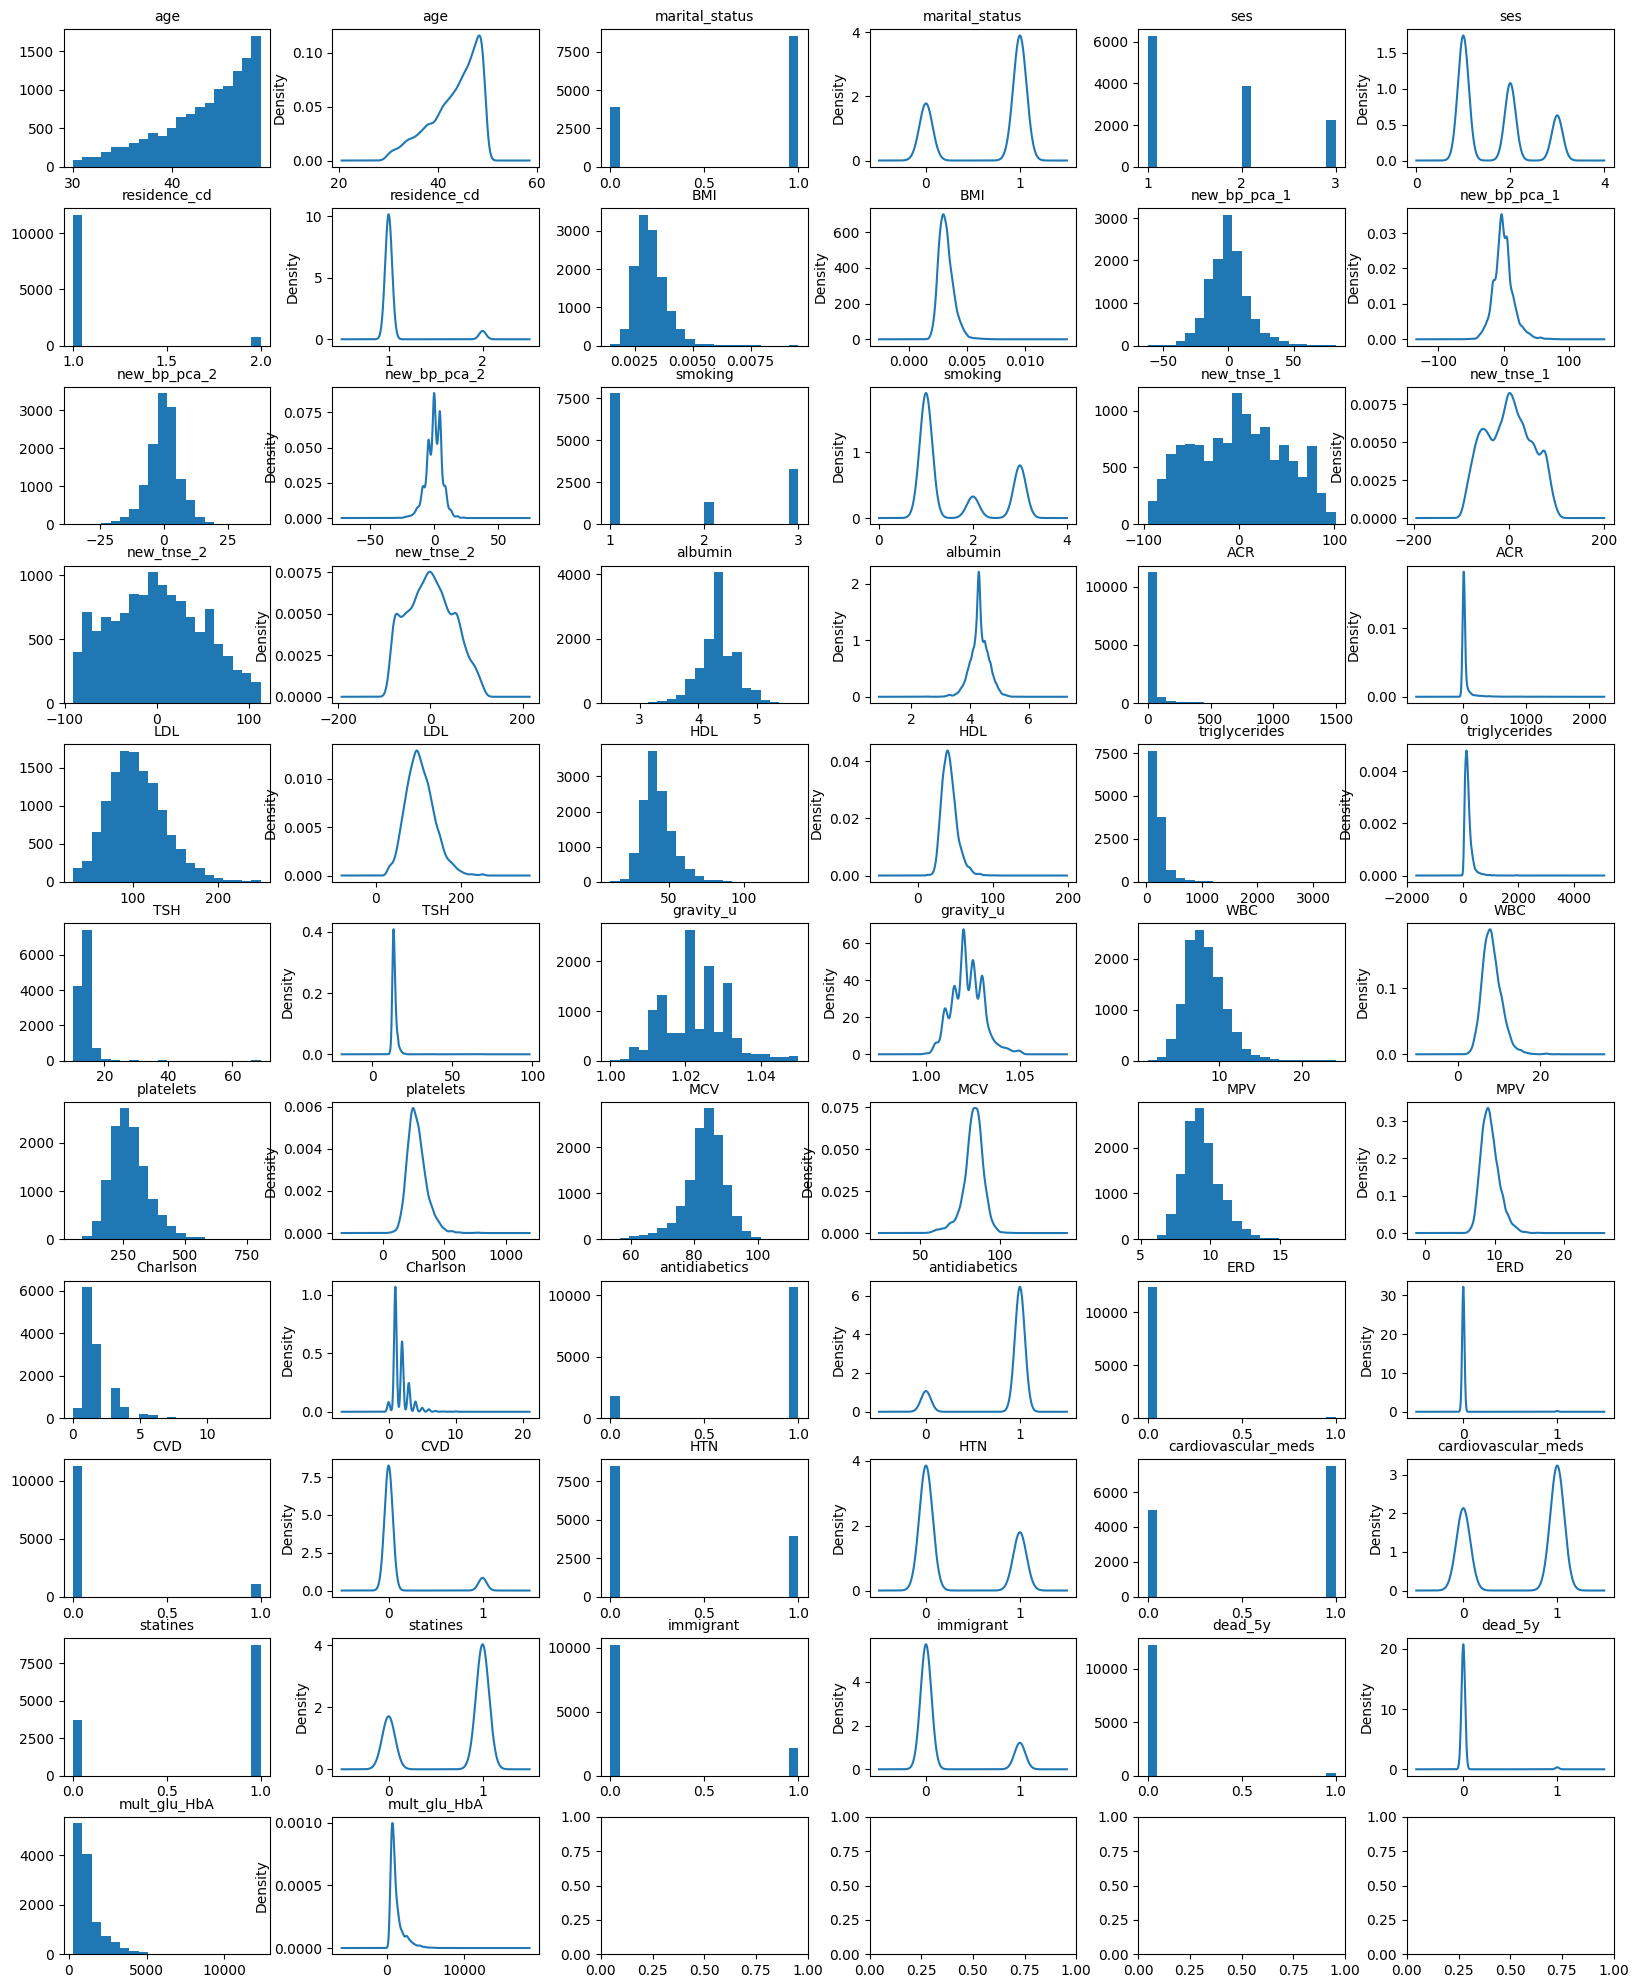

In [44]:
fig, axes = plt.subplots(nrows=11, ncols=6) 
fig.set_figheight(25)
fig.set_figwidth(20)
i = 0
j = 0
for col in train_df.columns:
  train_df.hist(column=col, bins=20, grid=False, ax=axes[i, j%3*2])
  train_df[col].plot.kde(ax=axes[i, j%3*2+1])
  title = col
  fontSize = 10
  colour = 'black'
  axes[i, j%3*2].set_title(title, fontsize=fontSize, color=colour)
  axes[i, j%3*2+1].set_title(title, fontsize=fontSize, color=colour)
  j += 1 
  if j % 3 == 0:
     i += 1

In [45]:
train_df.describe()

age  marital_status           ses  residence_cd           BMI  \
count  12438.000000    12438.000000  12438.000000  12438.000000  12438.000000   
mean      43.501126        0.686364      1.677279      1.062631      0.003187   
std        4.802035        0.463989      0.763641      0.242307      0.000649   
min       30.000000        0.000000      1.000000      1.000000      0.001453   
25%       41.000000        0.000000      1.000000      1.000000      0.002738   
50%       45.000000        1.000000      1.000000      1.000000      0.003101   
75%       48.000000        1.000000      2.000000      1.000000      0.003538   
max       49.000000        1.000000      3.000000      2.000000      0.009555   

       new_bp_pca_1  new_bp_pca_2       smoking    new_tnse_1    new_tnse_2  \
count  1.243800e+04  1.243800e+04  12438.000000  12438.000000  12438.000000   
mean   4.122268e-15  6.558153e-16      1.636678     -0.311763      0.299436   
std    1.509746e+01  6.121911e+00      0.871735     47.504292     49.172028   
min   -6.145859e+01 -3.537448e+01      1.000000    -95.726631    -90.907127   
25%   -8.344269e+00 -4.196398e+00      1.000000    -39.934968    -38.293388   
50%   -1.298131e+00  2.161271e-01      1.000000     -0.088472     -1.003490   
75%    6.799706e+00  4.407531e+00      3.000000     35.050464     36.889856   
max    8.209091e+01  3.769933e+01      3.000000    101.311104    113.139496   

       ...      Charlson  antidiabetics           ERD           CVD  \
count  ...  12438.000000   12438.000000  12438.000000  12438.000000   
mean   ...      1.755427       0.857694      0.006593      0.092057   
std    ...      1.218773       0.349378      0.080931      0.289117   
min    ...      0.000000       0.000000      0.000000      0.000000   
25%    ...      1.000000       1.000000      0.000000      0.000000   
50%    ...      1.000000       1.000000      0.000000      0.000000   
75%    ...      2.000000       1.000000      0.000000      0.000000   
max    ...     14.000000       1.000000      1.000000      1.000000   

                HTN  cardiovascular_meds      statines     immigrant  \
count  12438.000000         12438.000000  12438.000000  12438.000000   
mean       0.318058             0.602669      0.702203      0.174867   
std        0.465741             0.489365      0.457308      0.379869   
min        0.000000             0.000000      0.000000      0.000000   
25%        0.000000             0.000000      0.000000      0.000000   
50%        0.000000             1.000000      1.000000      0.000000   
75%        1.000000             1.000000      1.000000      0.000000   
max        1.000000             1.000000      1.000000      1.000000   

            dead_5y  mult_glu_HbA  
count  12438.000000  12438.000000  
mean       0.015839   1265.016736  
std        0.124856    891.027097  
min        0.000000    265.500000  
25%        0.000000    710.475000  
50%        0.000000    950.400000  
75%        0.000000   1464.000000  
max        1.000000  12362.000000  

[8 rows x 31 columns]

NORMALIZE - (if it's distributaion looks like normal its in the normal list, otherwise in the mixed list)

In [46]:
normal_dist_lst = ['BMI', 'albumin', 'LDL', 'HDL', 'gravity_u', 'WBC', 'platelets', 'MCV', 'MPV', 'new_bp_pca_1', 'new_bp_pca_2', 'new_tnse_1', 'new_tnse_2']
mixed_dist_lst = ['age', 'ACR', 'TSH', 'Charlson', 'mult_glu_HbA']
min_max = skl.preprocessing.MinMaxScaler()
train_df[normal_dist_lst] = min_max.fit_transform(train_df[normal_dist_lst])
normalize = skl.preprocessing.Normalizer()
train_df[mixed_dist_lst] = normalize.fit_transform(train_df[mixed_dist_lst])

# Data balancing

SMOTE-NC (Synthetic Minority Over-sampling Technique for Nominal and Continuous) is a technique for oversampling imbalanced datasets in machine learning. It combines the Synthetic Minority Over-sampling Technique (SMOTE) with the nearest neighbors correction for continuous features (NC). SMOTE-NC generates synthetic samples for the minority class by interpolating between minority class samples and their nearest neighbors. The nearest neighbors correction is applied to ensure the generated samples are consistent with the distribution of the continuous features in the minority cl

In [47]:


y = train_df['dead_5y']
x = train_df.copy()
x = x.drop('dead_5y', axis=1)
col_num_lst = col_to_num(x)
cat_list = list(train_df.columns)
for colname in train_df.columns:
    if colname in normal_dist_lst or colname in mixed_dist_lst or colname == 'dead_5y':
        cat_list.pop(cat_list.index(colname))
    else:
        cat_list[cat_list.index(colname)] = col_num_lst[colname]
cat_list

sm = SMOTENC(cat_list)
X_res, y_res = sm.fit_resample(x, y)
X_res.describe()

age  marital_status           ses  residence_cd           BMI  \
count  24482.000000    24482.000000  24482.000000  24482.000000  24482.000000   
mean       0.046609        0.412221      1.728985      1.031819      0.216176   
std        0.021703        0.492245      0.788349      0.175522      0.084185   
min        0.003695        0.000000      1.000000      1.000000      0.000000   
25%        0.029863        0.000000      1.000000      1.000000      0.155783   
50%        0.045203        0.000000      2.000000      1.000000      0.205783   
75%        0.061241        1.000000      2.000000      1.000000      0.262765   
max        0.177681        1.000000      3.000000      2.000000      1.000000   

       new_bp_pca_1  new_bp_pca_2       smoking    new_tnse_1    new_tnse_2  \
count  24482.000000  24482.000000  24482.000000  24482.000000  24482.000000   
mean       0.444876      0.475945      1.671187      0.495080      0.459956   
std        0.112927      0.082789      0.912294      0.221057      0.254456   
min        0.000000      0.000000      1.000000      0.000000      0.000000   
25%        0.374492      0.426666      1.000000      0.325455      0.256593   
50%        0.430429      0.483076      1.000000      0.494562      0.442881   
75%        0.498410      0.535071      3.000000      0.639867      0.646293   
max        1.000000      1.000000      3.000000      1.000000      1.000000   

       ...           MPV      Charlson  antidiabetics           ERD  \
count  ...  24482.000000  24482.000000   24482.000000  24482.000000   
mean   ...      0.296538      0.002074       0.876644      0.006290   
std    ...      0.097240      0.002074       0.328852      0.079063   
min    ...      0.000000      0.000000       0.000000      0.000000   
25%    ...      0.226037      0.000853       1.000000      0.000000   
50%    ...      0.281481      0.001440       1.000000      0.000000   
75%    ...      0.355556      0.002594       1.000000      0.000000   
max    ...      1.000000      0.028612       1.000000      1.000000   

                CVD           HTN  cardiovascular_meds      statines  \
count  24482.000000  24482.000000         24482.000000  24482.000000   
mean       0.084143      0.328731             0.645331      0.801895   
std        0.277609      0.469762             0.478423      0.398580   
min        0.000000      0.000000             0.000000      0.000000   
25%        0.000000      0.000000             0.000000      1.000000   
50%        0.000000      0.000000             1.000000      1.000000   
75%        0.000000      1.000000             1.000000      1.000000   
max        1.000000      1.000000             1.000000      1.000000   

          immigrant  mult_glu_HbA  
count  24482.000000  24482.000000  
mean       0.124867      0.989409  
std        0.330575      0.045347  
min        0.000000      0.348687  
25%        0.000000      0.996787  
50%        0.000000      0.998310  
75%        0.000000      0.999190  
max        1.000000      0.999991  

[8 rows x 30 columns]

In [48]:
x_train, x_test, y_train, y_test = skl.model_selection.train_test_split(X_res, y_res, test_size=0.2, train_size=0.8)


# Unsupervised learning

In [55]:
kmeans = skl.cluster.MiniBatchKMeans(n_clusters=3, verbose=0)
mini_kmeans = 'Mini Batch Kmeans'
clusterd_kmini, test_kmini_clusterd = clusterd_testClusted_data(kmeans, x_train, y_train, x_test, y_test)
mini_kmeans_c_rate = clustring_rate(clusterd_kmini, mini_kmeans)
mini_kmeans_ct_rate = clustring_rate(test_kmini_clusterd, mini_kmeans, test=True)
k_mini_batch = pd.concat([mini_kmeans_c_rate, mini_kmeans_ct_rate])
k_mini_batch

Model  Test data  Class  Dath rate  Total  Alive  Dead
0  Mini Batch Kmeans      False      0     0.5152   8596   4167  4429
1  Mini Batch Kmeans      False      1     0.5850   1330    552   778
2  Mini Batch Kmeans      False      2     0.4783   9659   5039  4620
0  Mini Batch Kmeans       True      0     0.5058   2084   1030  1054
1  Mini Batch Kmeans       True      1     0.5439    342    156   186
2  Mini Batch Kmeans       True      2     0.4751   2471   1297  1174

In [56]:
kmeans = skl.cluster.KMeans(n_clusters=3, verbose=0)
kmeans = 'Kmeans'
clusterd_kmeans, test_kmeans_clusterd = clusterd_testClusted_data(kmeans, x_train, y_train, x_test, y_test)
kmeans_c_rate = clustring_rate(clusterd_kmeans, kmeans)
kmeans_ct_rate = clustring_rate(test_kmeans_clusterd, kmeans, test=True)
k_means_acc = pd.concat([kmeans_c_rate, kmeans_ct_rate])
k_means_acc

Model  Test data  Class  Dath rate  Total  Alive  Dead
0  Kmeans      False      0     0.5307   3162   1484  1678
1  Kmeans      False      1     0.4970  16311   8205  8106
2  Kmeans      False      2     0.3839    112     69    43
0  Kmeans       True      0     0.4919    744    378   366
1  Kmeans       True      1     0.4933   4135   2095  2040
2  Kmeans       True      2     0.4444     18     10     8

In [ ]:
gm = skl.mixture.GaussianMixture(3, verbose=0)
gm_title = 'GaussianMixture'
clusterd_gm, test_gm_clusterd = clusterd_testClusted_data(gm, x_train, y_train, x_test, y_test)
mini_gm_c_rate = clustring_rate(clusterd_gm, gm_title)
mini_gm_ct_rate = clustring_rate(test_gm_clusterd, gm_title, test=True)
gm_acc = pd.concat([mini_gm_c_rate, mini_gm_ct_rate])
gm_acc

Model  Test data  Class  Dath rate  Total  Alive  Dead
0  GaussianMixture      False      0     0.4746  15005   7884  7121
1  GaussianMixture      False      1     0.7383   1777    465  1312
2  GaussianMixture      False      2     0.4973   2803   1409  1394
0  GaussianMixture       True      0     0.4705   3783   2003  1780
1  GaussianMixture       True      1     0.7181    447    126   321
2  GaussianMixture       True      2     0.4693    667    354   313

In [62]:
 test_kmeans_clusterd

age  marital_status  ses  residence_cd       BMI  new_bp_pca_1  \
21410  0.060992               0    3             1  0.115535      0.470812   
16620  0.035571               0    2             1  0.198670      0.803466   
22121  0.031403               0    2             1  0.223744      0.636802   
9432   0.010020               1    2             1  0.128590      0.345810   
13407  0.075526               0    3             1  0.086727      0.280967   
...         ...             ...  ...           ...       ...           ...   
1968   0.059377               1    2             1  0.443802      0.390045   
23768  0.027038               0    1             1  0.263442      0.324215   
21548  0.046621               0    2             1  0.182691      0.302382   
12648  0.032936               0    1             1  0.242997      0.311253   
2552   0.052565               1    1             1  0.144300      0.396486   

       new_bp_pca_2  smoking  new_tnse_1  new_tnse_2  ...  antidiabetics  ERD  \
21410      0.512008        1    0.905979    0.393817  ...              1    0   
16620      0.522671        3    0.603577    0.407021  ...              1    0   
22121      0.365125        3    0.546830    0.430658  ...              0    0   
9432       0.611795        1    0.497317    0.867730  ...              1    0   
13407      0.436777        3    0.483418    0.678302  ...              1    0   
...             ...      ...         ...         ...  ...            ...  ...   
1968       0.425871        1    0.679177    0.642896  ...              1    0   
23768      0.407376        3    0.563316    0.514604  ...              1    0   
21548      0.567225        1    0.597154    0.829771  ...              1    0   
12648      0.444103        1    0.378437    0.063470  ...              1    0   
2552       0.652077        1    0.617294    0.514665  ...              1    0   

       CVD  HTN  cardiovascular_meds  statines  immigrant  mult_glu_HbA  \
21410    0    0                    0         1          0      0.997627   
16620    0    1                    1         1          0      0.999204   
22121    0    0                    0         0          0      0.999214   
9432     0    0                    1         1          1      0.999941   
13407    0    0                    1         1          1      0.996892   
...    ...  ...                  ...       ...        ...           ...   
1968     0    1                    1         1          0      0.998064   
23768    0    1                    1         1          0      0.999503   
21548    0    0                    1         1          0      0.998786   
12648    0    1                    1         1          0      0.999275   
2552     0    0                    0         1          0      0.998509   

       class  dead_5y  
21410      0        1  
16620      2        1  
22121      0        1  
9432       0        0  
13407      0        1  
...      ...      ...  
1968       0        0  
23768      0        1  
21548      0        1  
12648      0        1  
2552       0        0  

[4897 rows x 32 columns]

In [63]:
test_clusterd_df = test_gm_clusterd
clusterd_df = clusterd_gm

# Supervised Learning

In [64]:
x_test = test_clusterd_df.drop('dead_5y', axis=1)
x_train = clusterd_df.drop('dead_5y', axis=1)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((19585, 31), (19585,), (4897, 31), (4897,))

In [65]:
# Creating random data variables for k-fold cross validation
clusterd_df = pd.concat([clusterd_df, test_clusterd_df])
kfold_set, temp1, kfold_target, temp2 = skl.model_selection.train_test_split(clusterd_df.drop('dead_5y', axis=1), clusterd_df['dead_5y'], train_size=0.8)
kfold_set.shape, kfold_target.shape, clusterd_df.shape

((19585, 31), (19585,), (24482, 32))

In [66]:
model_lst = []

In [67]:
log_reg = skl.linear_model.LogisticRegression()
model_lst.append(model_accuracy(log_reg, x_train, y_train, x_test, y_test, "Logistic Regression"))

In [68]:
svc = skl.svm.SVC() 
model_lst.append(model_accuracy(svc, x_train, y_train, x_test, y_test, "SVC"))

: 

: 

In [ ]:
l_svc= skl.svm.LinearSVC()
model_lst.append(model_accuracy(l_svc, x_train, y_train, x_test, y_test, "Linear SVC"))

In [ ]:
rfc = skl.ensemble.RandomForestClassifier(n_estimators=100, max_depth=50)
model_lst.append(model_accuracy(rfc, x_train, y_train, x_test, y_test, "Random Forest"))

In [ ]:
knc = skl.neighbors.KNeighborsClassifier()
model_lst.append(model_accuracy(knc, x_train, y_train, x_test, y_test, 'KNeighbors'))

In [ ]:
gnb= skl.naive_bayes.GaussianNB()
model_lst.append(model_accuracy(gnb, x_train, y_train, x_test, y_test, "GaussianNB"))

In [ ]:
percep = skl.linear_model.Perceptron()
model_lst.append(model_accuracy(percep, x_train, y_train, x_test, y_test, "Perceptron"))

In [ ]:
sdgc = skl.linear_model.SGDClassifier()
model_lst.append(model_accuracy(sdgc, x_train, y_train, x_test, y_test, "SGD"))

In [ ]:
dtc = skl.tree.DecisionTreeClassifier()
model_lst.append(model_accuracy(dtc, x_train, y_train, x_test, y_test, "Decision Tree"))

In [ ]:
mlp = skl.neural_network.MLPClassifier()
model_lst.append(model_accuracy(mlp, x_train, y_train, x_test, y_test, "Multilayer Percptron"))

In [ ]:


all_models = pd.DataFrame({})
sorted_models = pd.concat(model_lst, ignore_index=True)
sorted_models = sorted_models.sort_values(by=["K cross"], ascending=False)
sorted_models.set_index("Model", inplace=True)
sorted_models.style.apply(highlight_rows, axis=1)